In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import pickle
import math 

In [80]:
def drop_one_airport(adj,name):
    index_row = adj.columns.get_loc(name)
    adj[name]=0
    adj.loc[index_row]=0
    return adj
    
adj = pd.read_csv('./init_flight_capacity.csv')
# AAL is the airport to cutted all connection
adj_new = drop_one_airport(adj,'HKG').to_numpy()
# adj_new.shape

In [28]:
#adj.shape

In [29]:
#adj_new.shape

In [30]:
# adj
# s = pd.Series(airport_id)
# adj.set_index([s])

In [51]:
# adj_matrix contain the flight info with passenger num
# when cutted, rmb to change this file
# adj_matrix = np.load("init_flight_capacity.npy")
adj_matrix = adj_new
# adj_matrix = adj

with open("terminal_name.txt") as f:
    airport_id = f.readlines()
airport_id = [i.replace("\n", "") for i in airport_id]

with open('city_id2airports.pickle', 'rb') as handle:
    cityid2airportid = pickle.load(handle)

with open('cityid2population.pickle', 'rb') as handle:
    cityid2population = pickle.load(handle)
    
with open('cityid_passengers_from_to.pickle', 'rb') as handle:
    cityid_outprob = pickle.load(handle)
flights_data = pd.read_csv("flights.csv")
# flights_data
# adj_matrix.shape

In [52]:
#airport_id[154]

In [53]:
# fix nan
# cityid2population_e[3442] = 8604203.0
# cityid2population_e[86] = 7398000.0
# cityid2population_e[29867] = 593754.0


In [54]:
# cityid2airportid = {2451:["AAR", "AAL"],719:["ABI"] }       
# cityid2population = {2451: 237551.0, 719: 693494.0}
# cityid_outprob = {2451: {"AAR_PER": 0.4, "AAR_ABI": 0.3, "AAL_ABI":0.3}, 719: {"ABI_AAR": 1.0}}

beta_city = [0.779 for i in range(len(cityid2airportid))]
gamma_city = [0.03 for i in range(len(cityid2airportid))]
beta_flight = np.load("beta.npy") # infection rate
gamma_flight = np.copy(beta_flight)
gamma_flight[gamma_flight != 0] = 0.03 # recovery rate


In [502]:
def ppl_same_city_in_plane(airports, probabilities, infection_num_out):
    fetch = random.choices(airports, weights=probabilities, k=int(infection_num_out))

    infection_num_out_list=[]
    for item in airports:
        infection_num_out_list.append(fetch.count(item))
        
    return infection_num_out_list

def update_infection(arrive_infection_matrix):
    update_dictionary = dict(zip(airport_id, np.sum(arrive_infection_matrix, axis=0)))
    return update_dictionary

def get_infection_input(infection_dictionary):   
    city_infection_input = dict.fromkeys(cityid2airportid.keys(), 0)
    for k, v in cityid2airportid.items():
        infection_num = []
        for i in v:
            infection_num.append(infection_dictionary[i])
        city_infection_input[k] = sum(infection_num)
    return city_infection_input

def city_infection(city_infection_input, city_recovery):
    city_infection_num = np.array(list(city_infection_input.values()))
    city_population = np.array(list(cityid2population.values()))
    y_c = [(city_population - city_infection_num)/city_population, city_infection_num/city_population, city_recovery]
    
    s, i ,r = SIR(y_c, beta_city, gamma_city)
    
    after_infection = np.ceil(i*city_population)
    return r, after_infection


def flight_infection(flight_adj, flight_infection_num):

    y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
           np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
           np.zeros(len(flight_adj))]
    
    
    s, i ,r = SIR(y_f, beta_flight, gamma_flight)
    
    arrive_infection = np.nan_to_num(np.ceil(i*flight_adj), nan = 0)
    
    infection_ppl_flight = update_infection(arrive_infection)
    
    return infection_ppl_flight

def get_on_plane(flight_infection_matrix, infection_ppl_in_airport):
    for (k, v), num_of_people in zip(cityid_outprob.items(), infection_ppl_in_airport):
        people_on_plane = ppl_same_city_in_plane(list(v.keys()), list(v.values()), num_of_people)
        flight_infection_matrix = update_flight_infection(flight_infection_matrix, list(v.keys()), people_on_plane)
    return flight_infection_matrix
    
def fly_infection_ppl(city_infection_ppl):
    return np.nan_to_num(np.ceil(city_infection_ppl/1),nan = 1)
    

def SIR(y, beta, gamma):
    S, I, R = y 
    d0 = S - beta*S*I # derivative of S(t)
    d1 = I + beta*S*I - gamma*I # derivative of I(t)
    d2 = R+ gamma*I # derivative of R(t)
    
    return [d0, d1, d2]

def update_flight_infection(flight_infection, flight_com, ppl_num_list):
    flight_com = [i.split("_") for i in flight_com]
    for (flight_from, flight_to), infection_num in zip(flight_com, ppl_num_list):
        flight_from_id = airport_id.index(flight_from)
        flight_to_id = airport_id.index(flight_to)
        flight_infection[flight_from_id][flight_to_id] += infection_num
    return flight_infection
    

def loop_infection(n_iter, flight_adj):
    flight_infection_num = np.zeros((len(flight_adj), len(flight_adj)))
    #   flight_infection_num[fromcity][Tocity] = num_of_start_infection
    #   fromcity means the order from terminal_name file, AAL -> 0
    # flight_infection_num[75][339] = 1
    flight_infection_num[0][1] = 1
    
    city_recovery = [0.03 for i in range(len(cityid2airportid))]
    infection_ppl_list = [1]
    infection_ppl_city_list = []
    infection_ppl_flight_list = []
    
    for _ in tqdm(range(n_iter)):
        infection_ppl_flight = flight_infection(flight_adj, flight_infection_num)
        infection_ppl_flight_list.append(infection_ppl_flight)
        
        infection_ppl_city = get_infection_input(infection_ppl_flight)
        infection_ppl_city_list.append(infection_ppl_city)
        
        city_recovery, infection_ppl = city_infection(infection_ppl_city, city_recovery)
        
        flight_infection_num = get_on_plane(np.zeros((len(flight_adj), len(flight_adj))), fly_infection_ppl(infection_ppl))
        infection_ppl_list.append(np.sum(infection_ppl))
    
    return flight_infection_num, infection_ppl_list, infection_ppl_city_list, infection_ppl_flight_list
        

#  10-> loop iter, adj_matrix could be init or cutted matrix load from beginning
#matrix, infection_list, infection_ppl_city_list_, infection_ppl_flight_list_ = loop_infection(50, adj_matrix)
#print(infection_list,infection_ppl_city_list_,infection_ppl_flight_list_)
#matrix

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/4115505682.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/4115505682.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


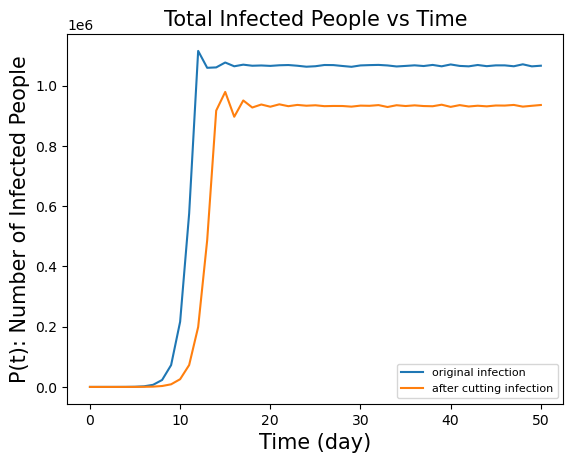

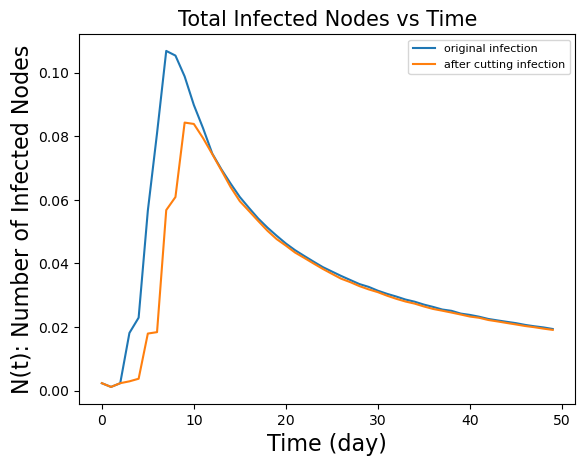

In [428]:
# eigenvector_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

In [430]:
print(infection_ppl_flight_list_)

[{'AAL': 0.0, 'AAR': 2.0, 'ABQ': 0.0, 'ABV': 0.0, 'ABX': 0.0, 'ABZ': 0.0, 'ACC': 0.0, 'ADE': 0.0, 'ADL': 0.0, 'AEP': 0.0, 'AKJ': 0.0, 'AKL': 0.0, 'ALC': 0.0, 'ALP': 0.0, 'ALY': 0.0, 'AMM': 0.0, 'AMS': 0.0, 'ANF': 0.0, 'AOJ': 0.0, 'AQP': 0.0, 'ARI': 0.0, 'ARM': 0.0, 'ARN': 0.0, 'ASJ': 0.0, 'ASP': 0.0, 'ATH': 0.0, 'ATL': 0.0, 'AUA': 0.0, 'AUH': 0.0, 'AUS': 0.0, 'AXT': 0.0, 'AYT': 0.0, 'AZO': 0.0, 'BCN': 0.0, 'BDB': 0.0, 'BDL': 0.0, 'BEY': 0.0, 'BGI': 0.0, 'BHM': 0.0, 'BIO': 0.0, 'BJZ': 0.0, 'BKI': 0.0, 'BKK': 0.0, 'BLQ': 0.0, 'BLR': 0.0, 'BME': 0.0, 'BMI': 0.0, 'BNA': 0.0, 'BNE': 0.0, 'BOD': 0.0, 'BOG': 0.0, 'BOS': 0.0, 'BRU': 0.0, 'BUD': 0.0, 'BUF': 0.0, 'BUR': 0.0, 'BWI': 0.0, 'BZE': 0.0, 'CAI': 0.0, 'CAN': 0.0, 'CBR': 0.0, 'CCP': 0.0, 'CCS': 0.0, 'CDG': 0.0, 'CGK': 0.0, 'CHA': 0.0, 'CHC': 0.0, 'CID': 0.0, 'CIX': 0.0, 'CJA': 0.0, 'CJC': 0.0, 'CKG': 0.0, 'CLE': 0.0, 'CLO': 0.0, 'CLT': 0.0, 'CMB': 0.0, 'CMH': 0.0, 'CMI': 0.0, 'CMN': 0.0, 'CNF': 0.0, 'CNS': 0.0, 'COS': 0.0, 'CPH': 0.0, 'C

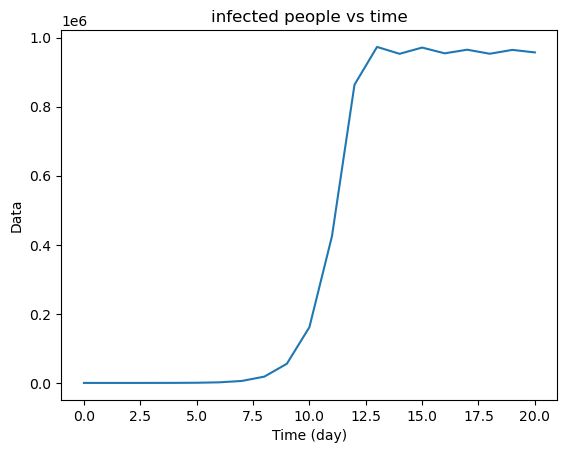

In [48]:
# full network
import matplotlib.pyplot as plt

# Time data (in months)
time = [i for i in range(len(infection_list))]

# Data to be plotted
data = infection_list

# Create the plot
plt.plot(time, data)

# Add a title and labels to the plot
plt.title('infected people vs time')
plt.xlabel('Time (day)')
plt.ylabel('Data')

# Show the plot
plt.show()


In [478]:
adj_matrix = pd.read_csv('./init_flight_capacity.csv')
matrix_ori, infection_list_ori, infection_ppl_city_list_ori, infection_ppl_flight_list_ori = loop_infection(50, adj_matrix)

  0%|          | 0/50 [00:00<?, ?it/s]

In [481]:
matrix_ori

array([[  0.,   8.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,  94.],
       [  0.,   0.,   0., ...,   0., 138.,   0.]])

In [482]:
import numpy as np
np.save("matrix_after_i.npy",matrix_ori) 

In [ ]:
plt.xlabel('Time (day)', fontsize=15)
    plt.ylabel("Number of Infected Nodes", fontsize=15)
    plt.title("Total Infected Nodes vs Time", fontsize=15)
    plt.legend(handles=[line1,line2], labels=["original infection","after cutting infection"], loc="best", fontsize=8)

In [388]:
# plot
def plot_iteration(infection_list):
    # Time data (in months)
    time = [i for i in range(len(infection_list))]

    # Data to be plotted
    data = infection_list
    data_ori = infection_list_ori

    # Create the plot
    l1,=plt.plot(time, data_ori)
    l2,=plt.plot(time, data)

    # Add a title and labels to the plot
    plt.title('Total Infected People vs Time', fontsize=15)
    plt.xlabel('Time (day)', fontsize=15)
    plt.ylabel('P(t): Number of Infected People', fontsize=15)
    
    plt.legend(handles=[l1,l2], labels=["original infection","after cutting infection"], loc="best", fontsize=8)

    # Show the plot
    plt.show()

In [371]:
# cut node
adj = pd.read_csv('./init_flight_capacity.csv')
#adj_new = drop_one_airport(adj,'VLC')
adj_matrix=adj

In [372]:
#matrix_ori,infection_list_ori,infection_ppl_city_list_ori,infection_ppl_flight_list_ori=loop_infection(20, adj_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

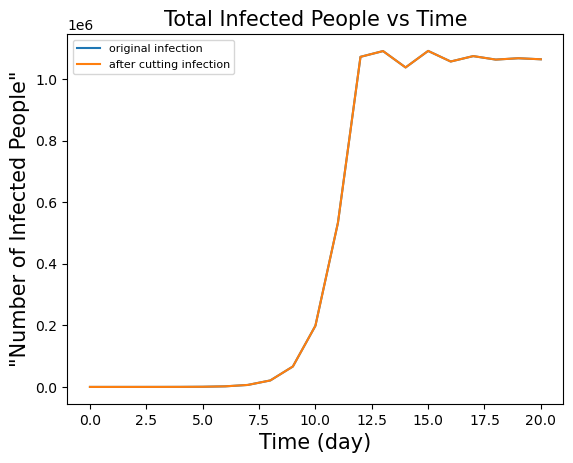

In [374]:
# full network
plot_iteration(infection_list_ori)

## cut one node

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: invalid value encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: invalid value encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: divide by zero encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: divide by zero encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6

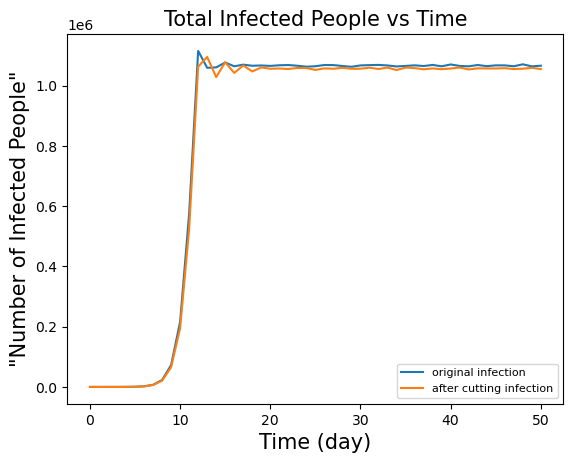

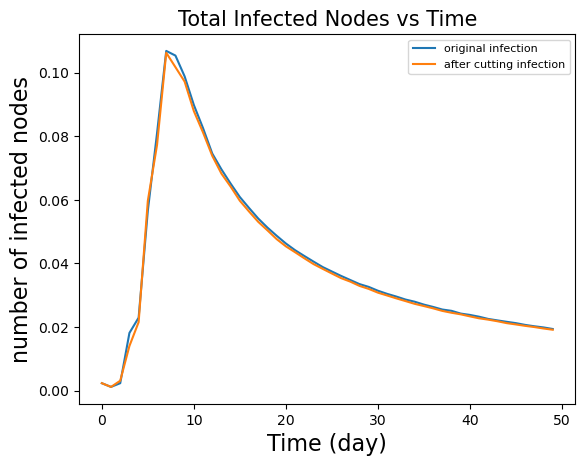

In [384]:
# cut node
adj = pd.read_csv('./init_flight_capacity.csv')
adj_new = drop_one_airport(adj,'AMM').to_numpy()
adj_matrix=adj_new
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

In [306]:
ite_t=[]
inf_n_a=[]
inf_n_b=[]
total_node_a=0
total_node_b=0
# for i in range(20):
#     ite_t.append(i)
# ite_t 

In [307]:
# i: day, j: airport
total_node_a=0
for i in infection_ppl_flight_list_:
    inf_n=0
    for j in i:
        total_node_a+=1
        if i[j]>0:
            inf_n+=1
    inf_n_a.append(inf_n/total_node_a)
    
total_node_b=0
for i in infection_ppl_flight_list_ori:
    inf_n=0
    for j in i:
        total_node_b+=1
        if i[j]>0:
            inf_n+=1
    inf_n_b.append(inf_n/total_node_b)

In [308]:
def node_ratio(infection_ppl_flight_list):
    total_node=0
    inf_n_r=[]
    for i in infection_ppl_flight_list:
        inf_n=0
        for j in i:
            total_node+=1
            if i[j]>0:
                inf_n+=1
        inf_n_r.append(inf_n/total_node)
    return inf_n_r

In [309]:
inf_n_b=node_ratio(infection_ppl_flight_list_ori)
inf_n_a=node_ratio(infection_ppl_flight_list_)

In [312]:
# line1,= plt.plot(ite_t, inf_n_b)
# line2,= plt.plot(ite_t, inf_n_a)
# plt.xlabel("iteration", fontsize=16)
# plt.ylabel("number of infected nodes", fontsize=16)
# plt.title("Total Infected Nodes vs Time", fontsize=15)
# plt.legend(handles=[line1,line2], labels=["original infection","after cutting infection"], loc="best", fontsize=8)

In [389]:
def plt_node_ratio(infection_ppl_flight_list):
    ite_t=[]
    for i in range(len(infection_ppl_flight_list)):
        ite_t.append(i)
    
    inf_n_b=node_ratio(infection_ppl_flight_list_ori)
    inf_n_a=node_ratio(infection_ppl_flight_list)
    
    line1,= plt.plot(ite_t, inf_n_b)
    line2,= plt.plot(ite_t, inf_n_a)
    plt.xlabel("Time (day)", fontsize=16)
    plt.ylabel("N(t): Number of Infected Nodes", fontsize=16)
    plt.title("Total Infected Nodes vs Time", fontsize=15)
    plt.legend(handles=[line1,line2], labels=["original infection","after cutting infection"], loc="best", fontsize=8)

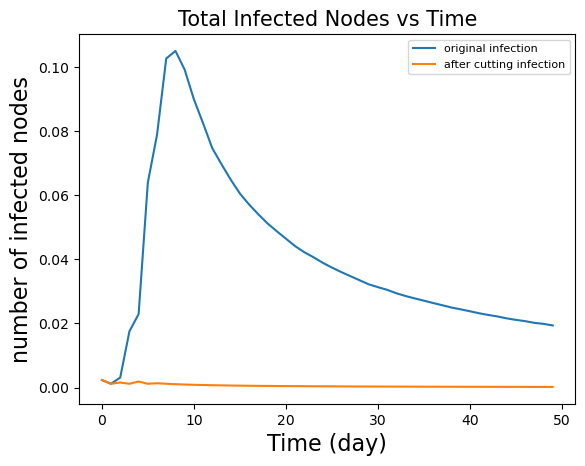

In [369]:
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: invalid value encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: invalid value encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: divide by zero encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: divide by zero encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6

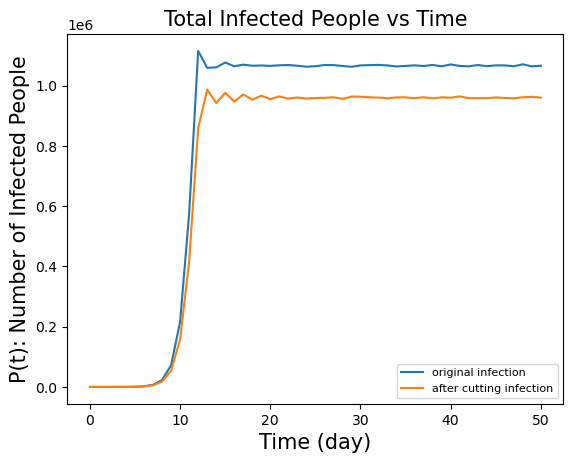

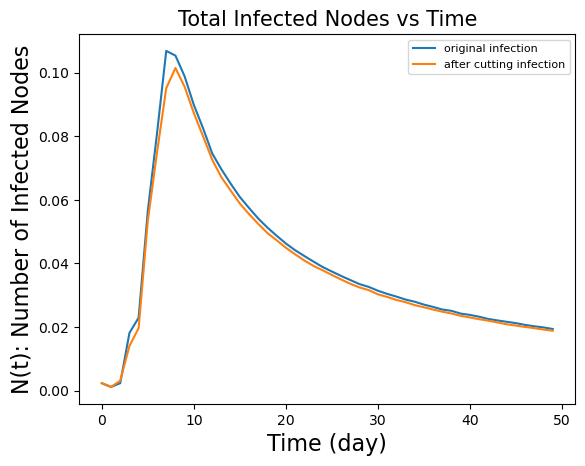

In [390]:
# cut node
adj = pd.read_csv('./init_flight_capacity.csv')
adj_new = drop_one_airport(adj,'HKG').to_numpy()
adj_matrix=adj_new
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: invalid value encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: invalid value encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: divide by zero encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: divide by zero encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6

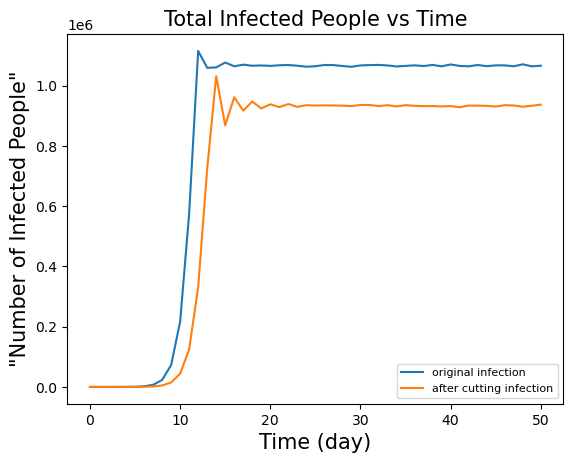

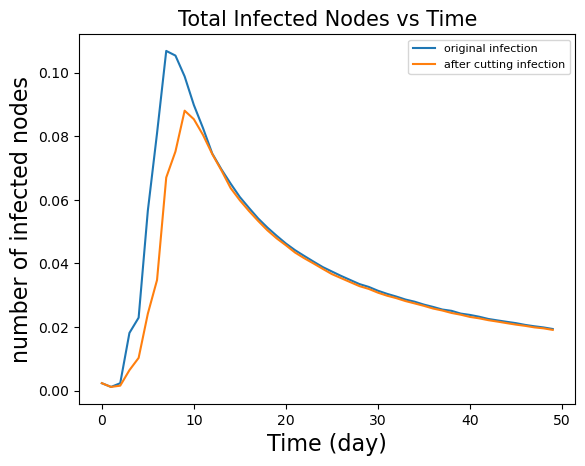

In [386]:
# cut node
adj = pd.read_csv('./init_flight_capacity.csv')
adj_new = drop_one_airport(adj,'LHR').to_numpy()
adj_matrix=adj_new
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: invalid value encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: invalid value encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:36: RuntimeWarning: divide by zero encountered in divide
  y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:37: RuntimeWarning: divide by zero encountered in divide
  np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6

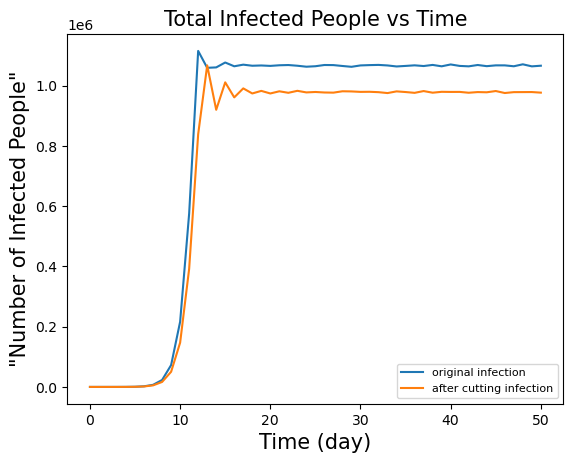

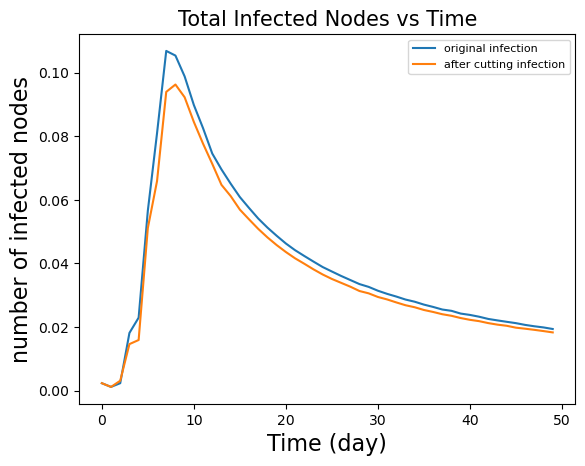

In [387]:
# cut node
adj = pd.read_csv('./init_flight_capacity.csv')
adj_new = drop_one_airport(adj,'ORD').to_numpy()
adj_matrix=adj_new
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## cut top 3 nodes

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


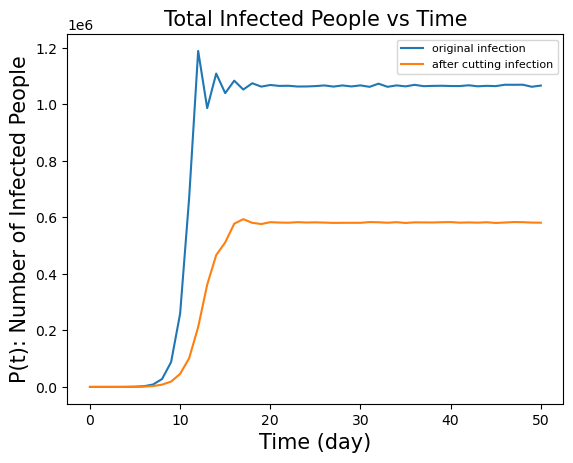

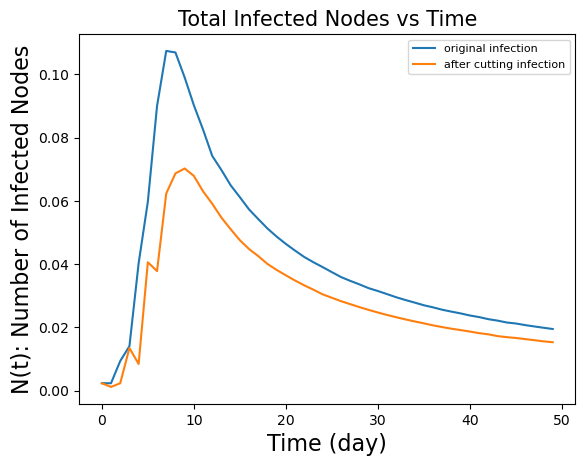

In [503]:
# degree_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'MAD', 'MIA', 'HKG', 'STL', 'LAX', 'BCN', 'NRT'] 
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


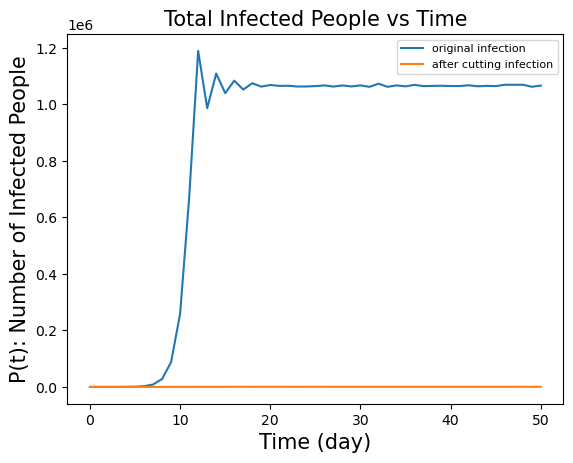

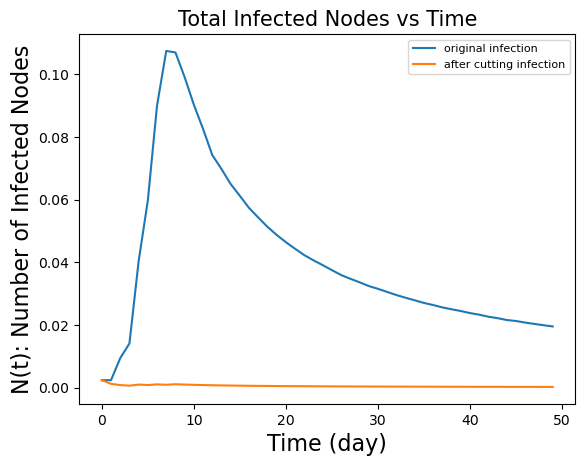

In [504]:
# degree_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


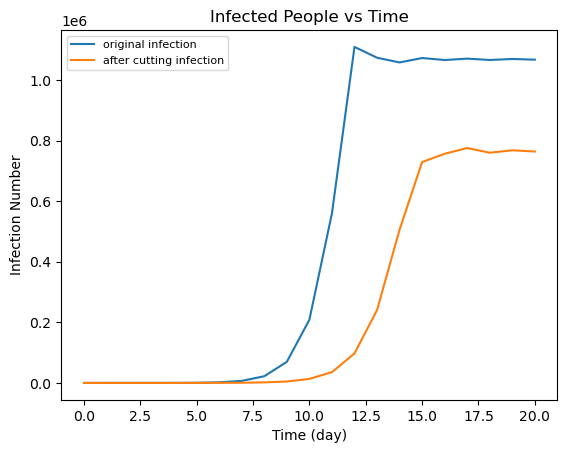

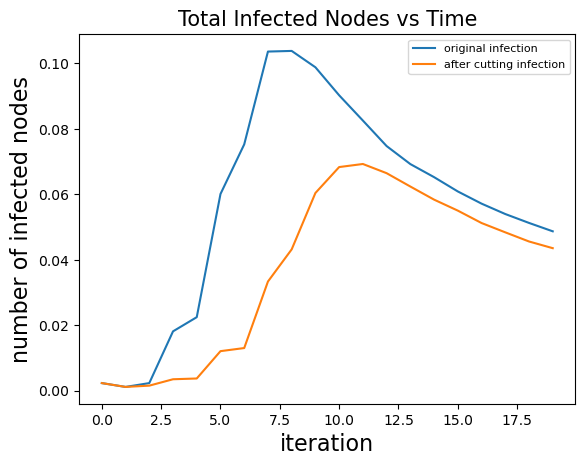

In [318]:
# degree_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MAD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


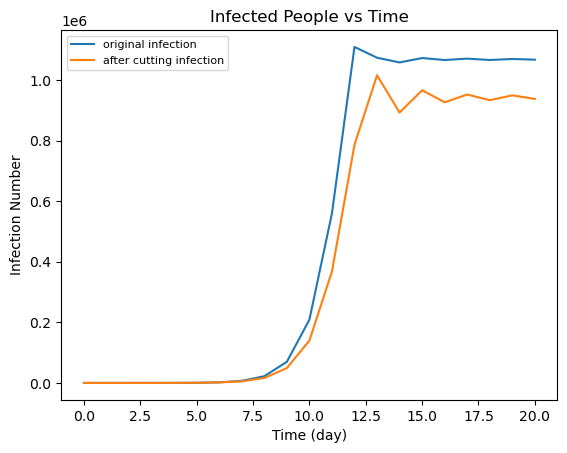

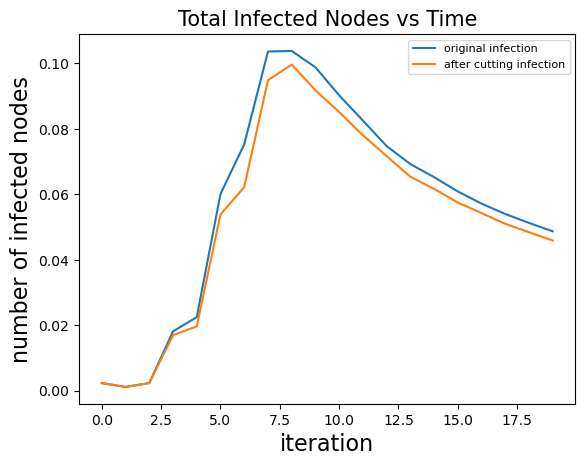

In [319]:
# betweenness_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['AMM', 'BCN', 'HKG']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


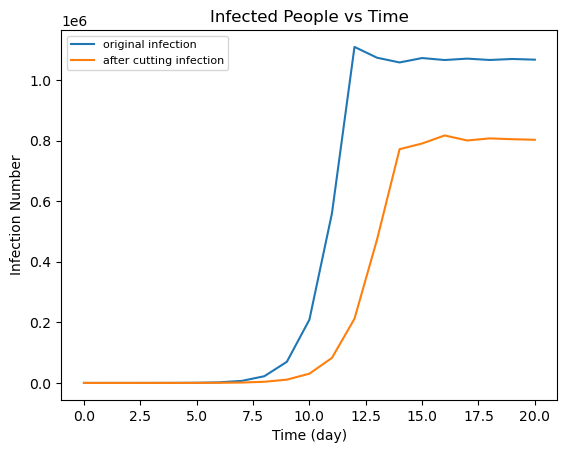

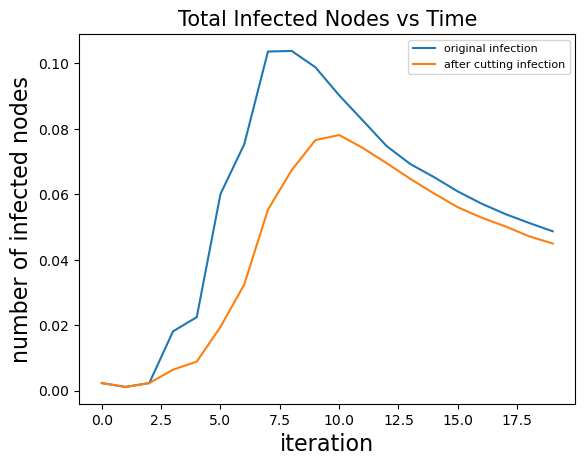

In [320]:
# closeness_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'JFK', 'ORD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


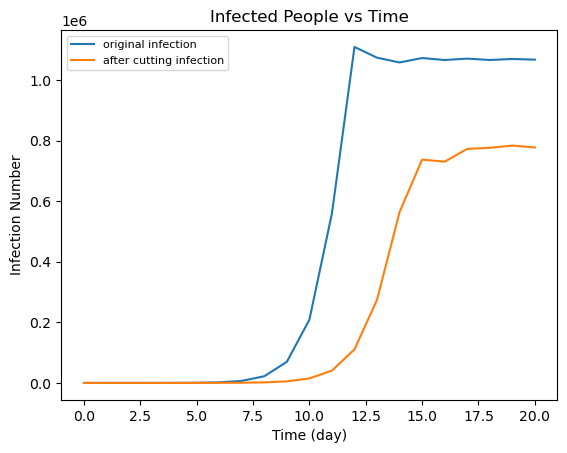

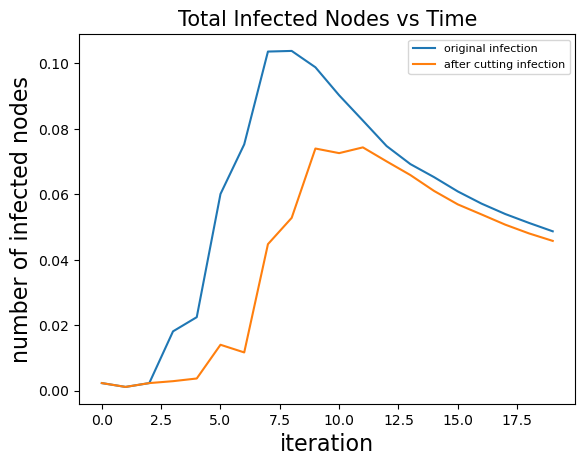

In [321]:
# eigenvector_centrality cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


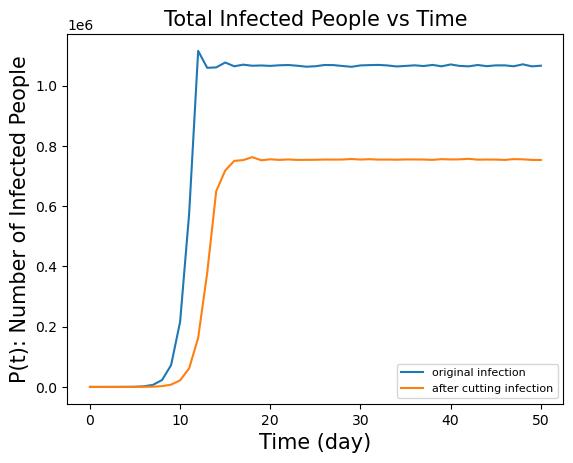

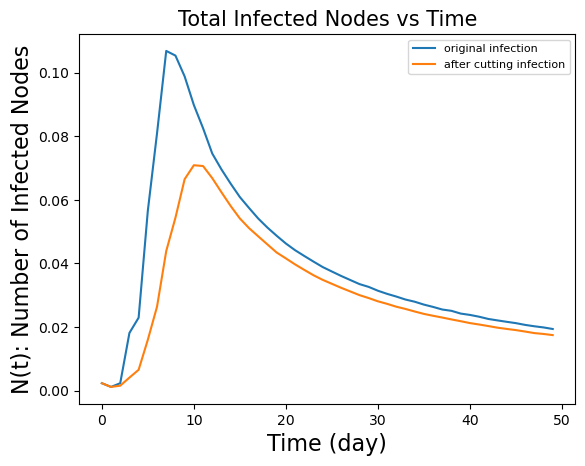

In [392]:
# page_rank
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'ORD', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


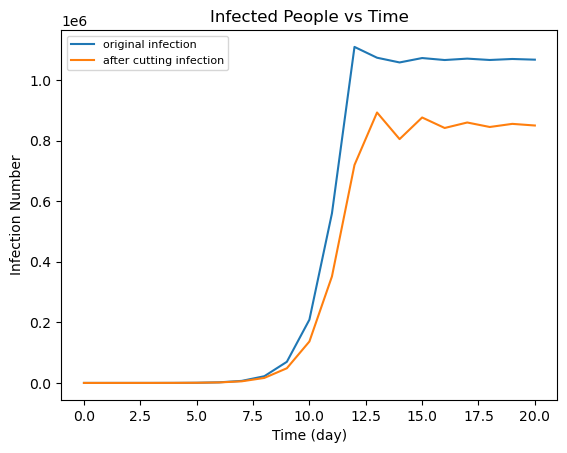

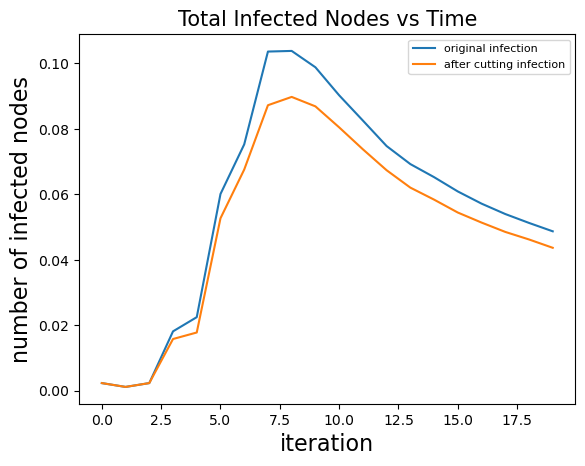

In [323]:
# h_index cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LAX', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


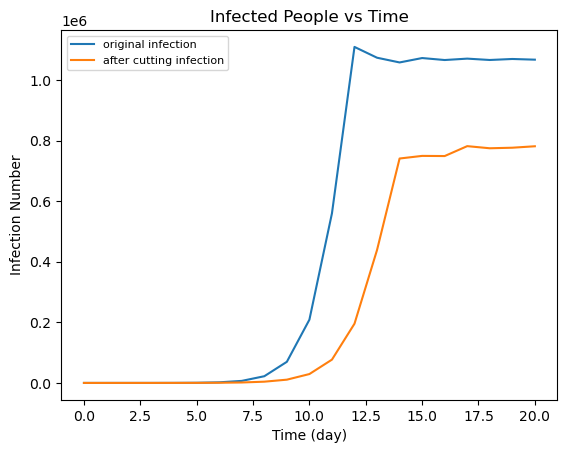

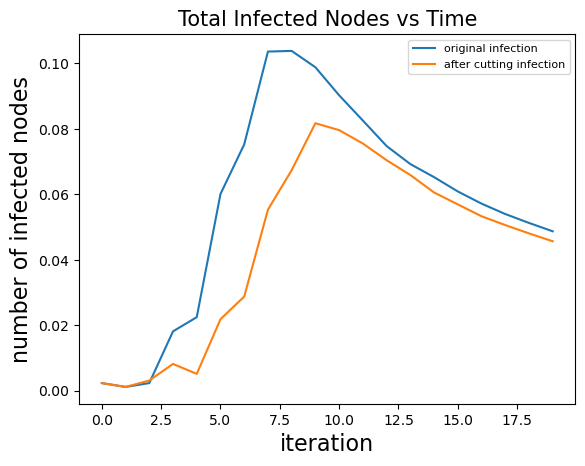

In [324]:
# hits_hub cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


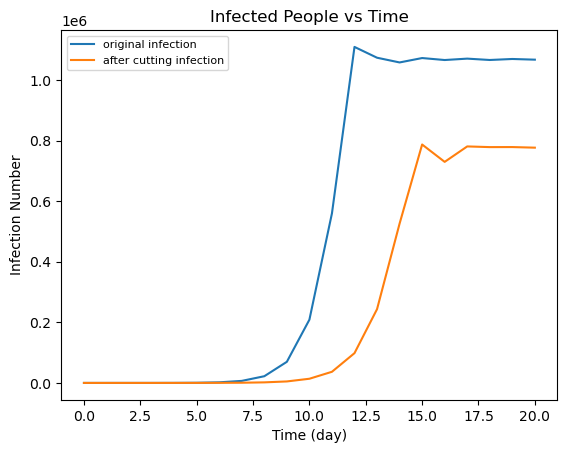

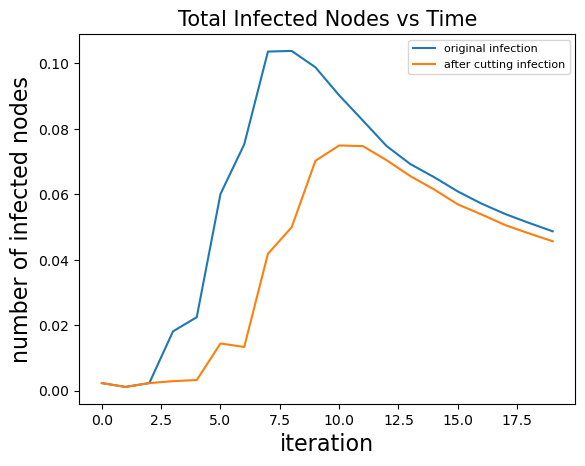

In [325]:
# hits_aut cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


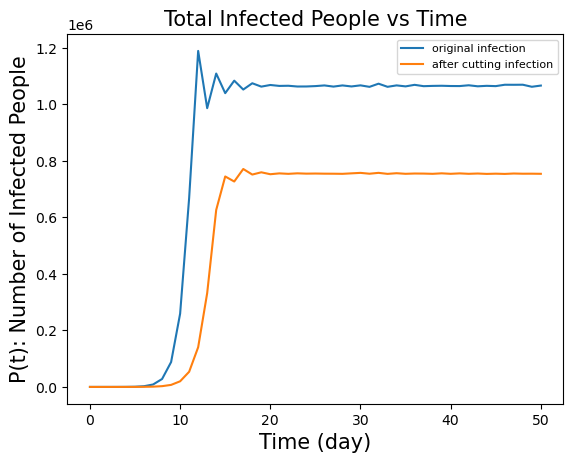

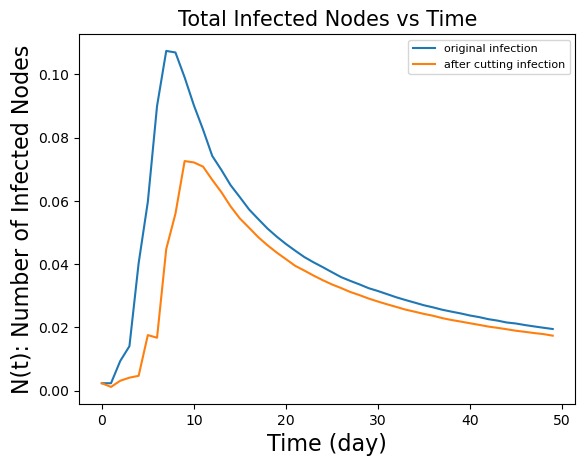

In [506]:
# gls cut node
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## biggest airport cut node

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1463821270.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


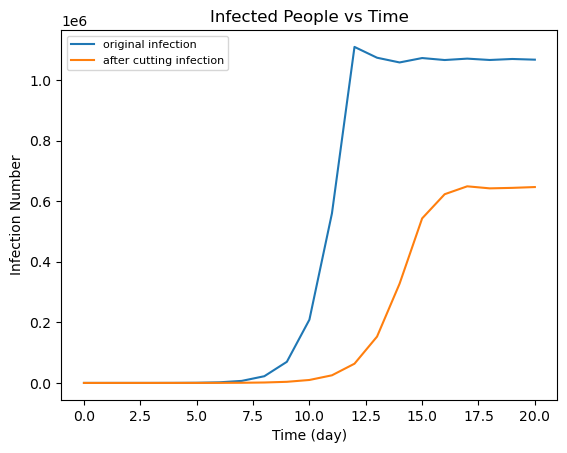

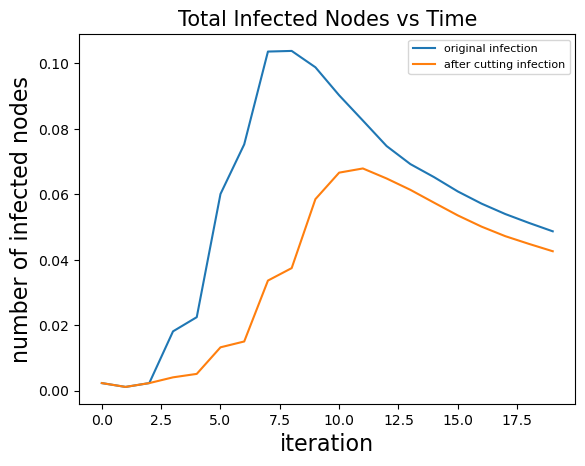

In [327]:
# biggest airport cut node
adj = pd.read_csv('./init_flight_capacity.csv')
adj_new = drop_one_airport(adj,'ATL')
adj_new = drop_one_airport(adj_new,'PEK')
adj_new = drop_one_airport(adj_new,'LAX')
adj_new = drop_one_airport(adj_new,'DXB')
adj_new = drop_one_airport(adj_new,'HND')
adj_new = drop_one_airport(adj_new,'ORD')
adj_new = drop_one_airport(adj_new,'LHR')
adj_new = drop_one_airport(adj_new,'PVG')
adj_new = drop_one_airport(adj_new,'CDG')
#adj_new = drop_one_airport(adj_new,'DFW')
adj_matrix=adj_new
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(20, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## cut top 10 nodes

In [328]:
def cut_k_nodes(adj, node_list):
    for i in node_list:
        adj=drop_one_airport(adj,i)
    return adj

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


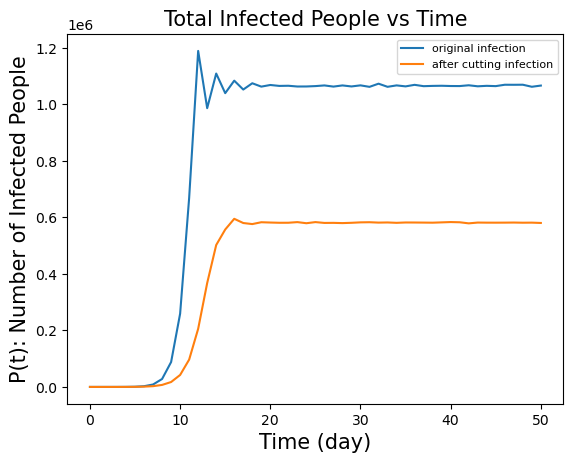

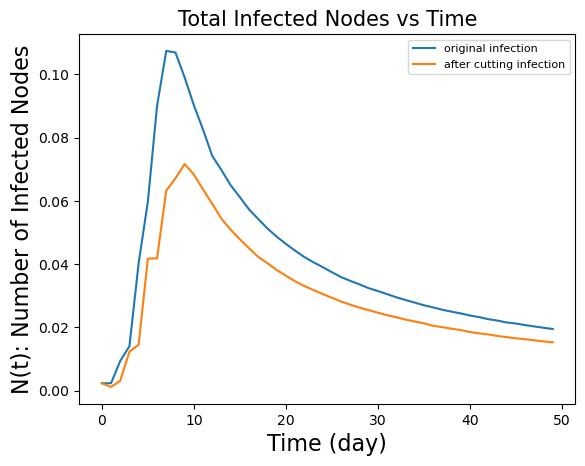

In [507]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'MAD', 'MIA', 'HKG', 'STL', 'LAX', 'BCN', 'NRT']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/2310611930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


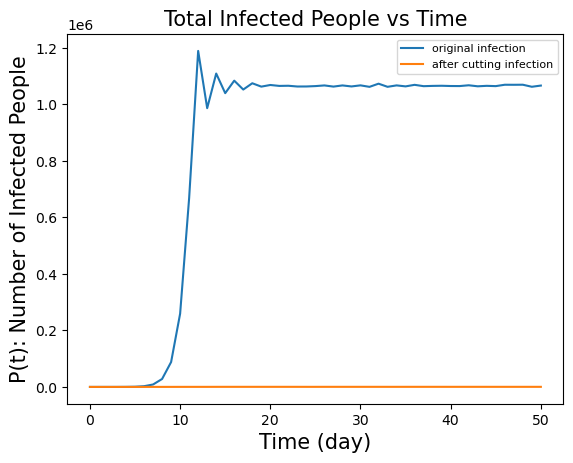

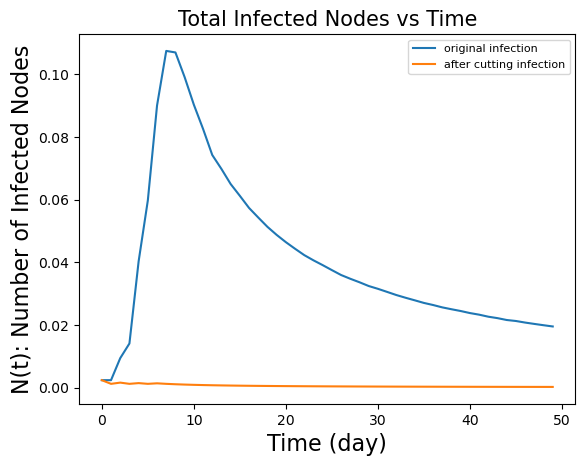

In [508]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


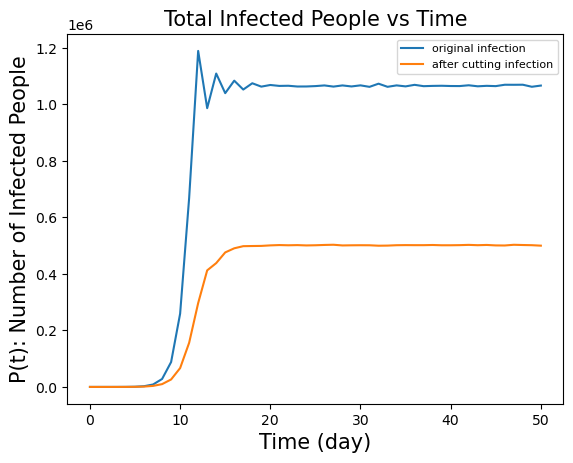

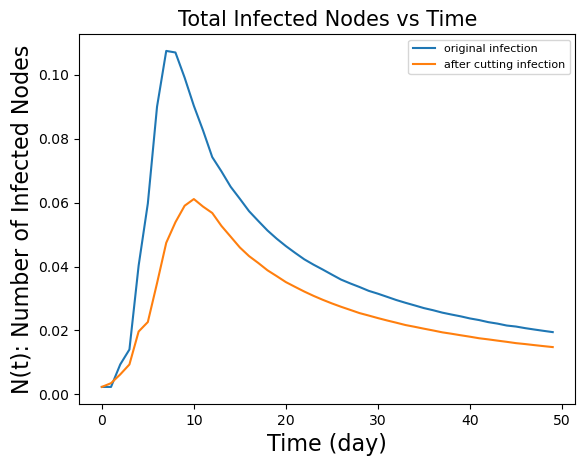

In [498]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MAD', 'MIA', 'HKG', 'STL', 'HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


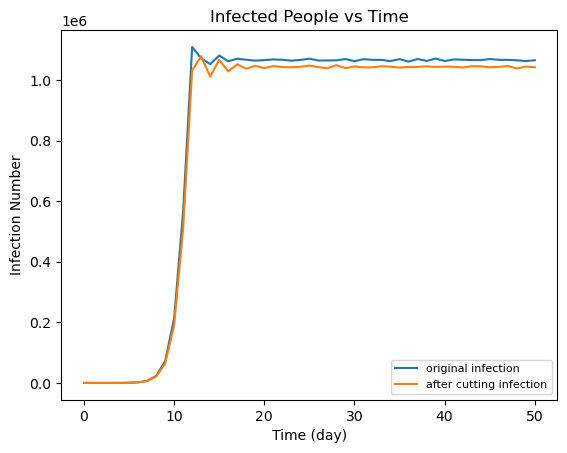

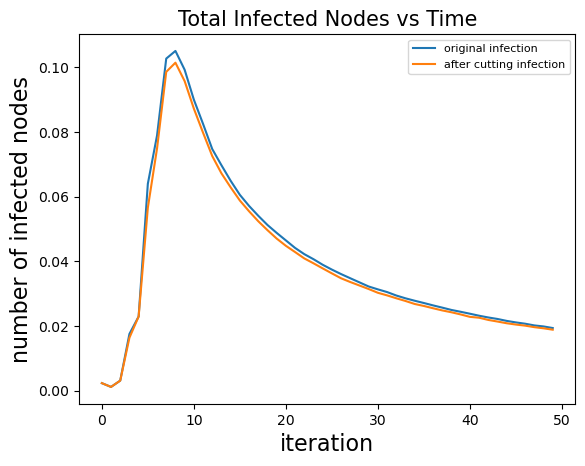

In [337]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


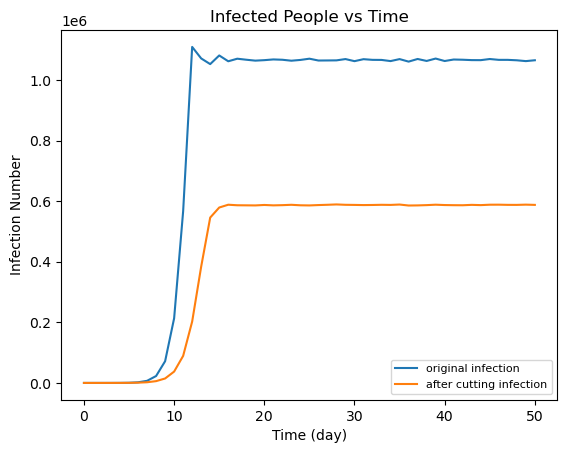

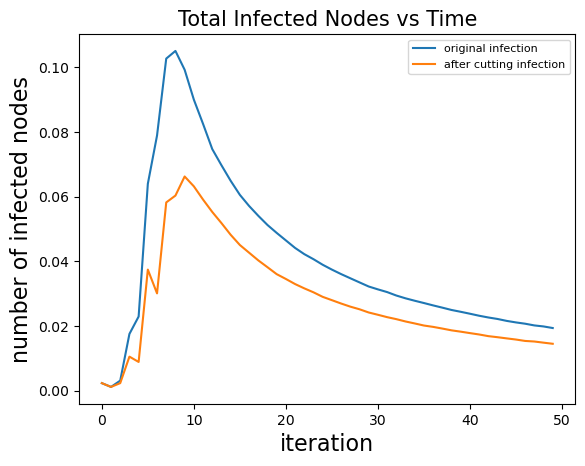

In [338]:
# betweenness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['AMM', 'BCN', 'HKG', 'MAD', 'SCL', 'ORD', 'HEL', 'MIA', 'BOS', 'STL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


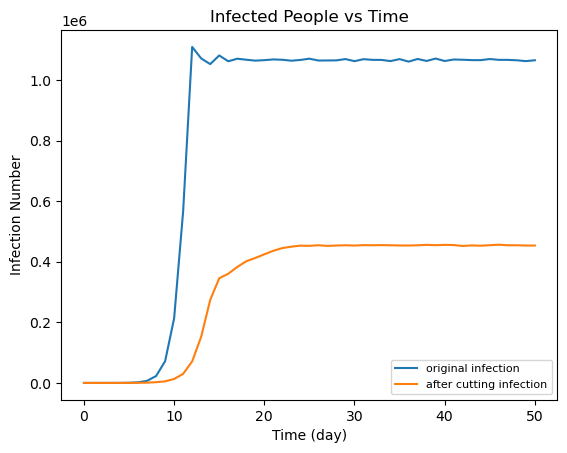

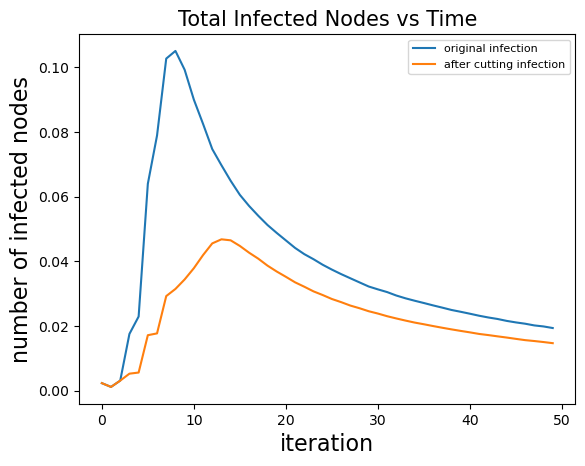

In [339]:
# closeness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'JFK', 'ORD', 'MAD', 'LAX', 'MIA', 'FRA', 'BCN', 'AMM', 'HKG']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


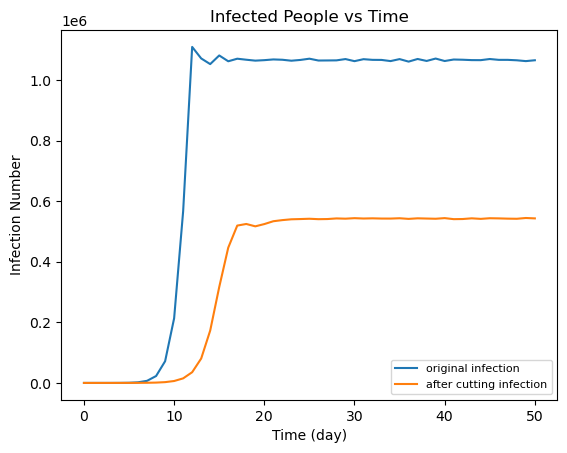

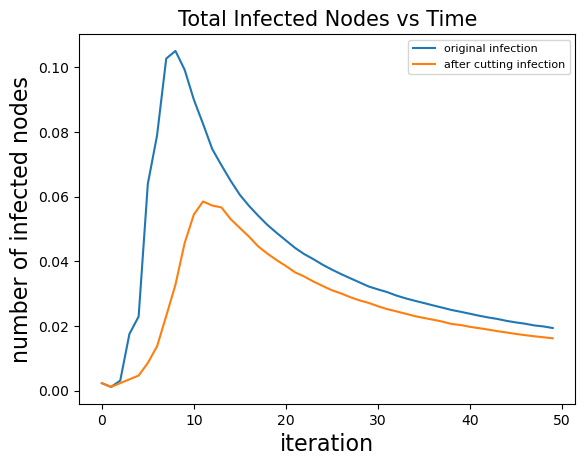

In [340]:
# eigenvector_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'NRT', 'JFK', 'LAX', 'TPE', 'MEL', 'PVG', 'ORD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


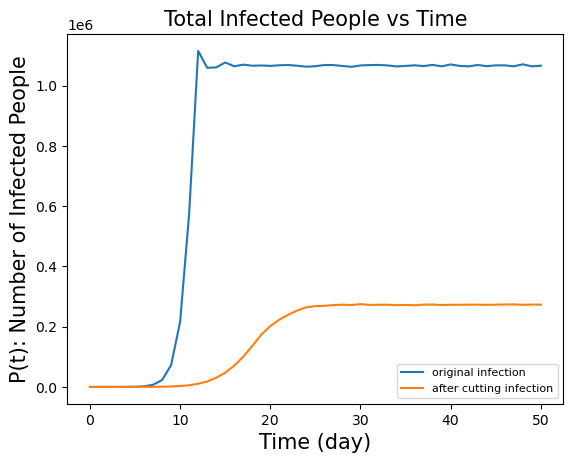

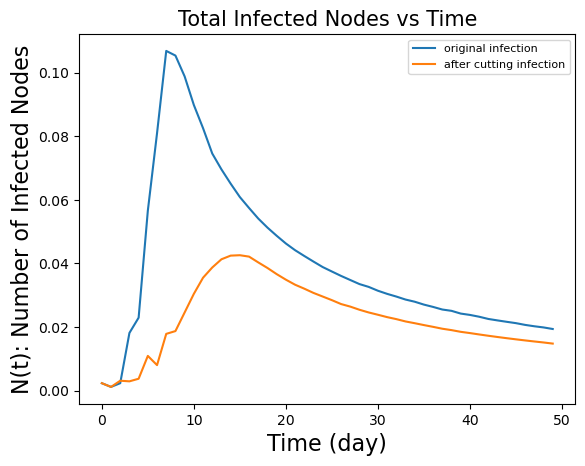

In [394]:
# page_rank
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'ORD', 'MIA', 'HKG', 'MAD', 'HND', 'LAX', 'SYD', 'JFK', 'SCL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


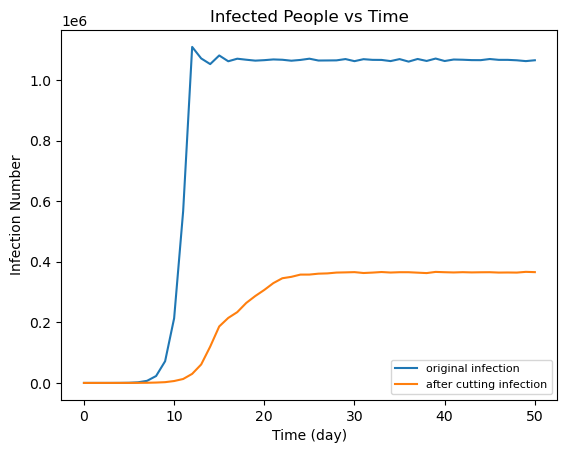

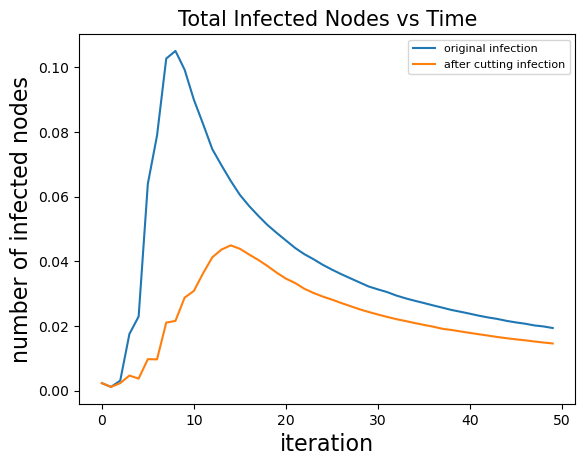

In [342]:
# h_index
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LAX', 'MIA', 'LHR', 'JFK', 'HKG', 'STL', 'MAD', 'NRT', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


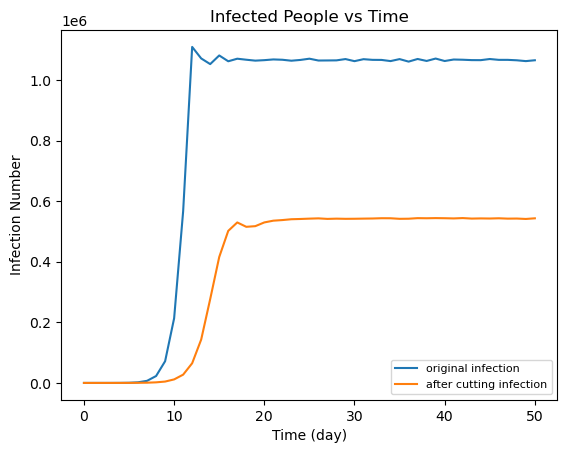

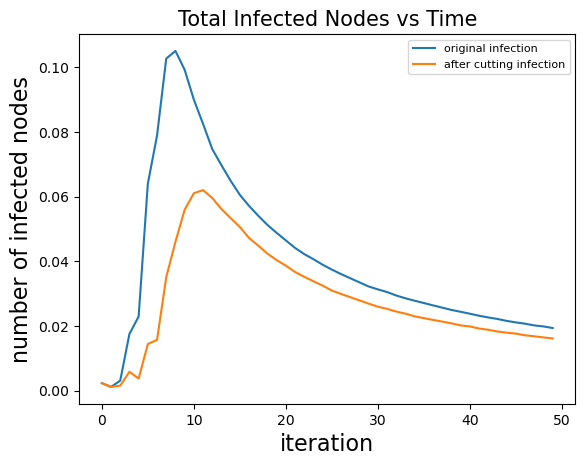

In [343]:
# hits_hub
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'TPE', 'NRT', 'JFK', 'LAX', 'PVG', 'MEL', 'ORD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


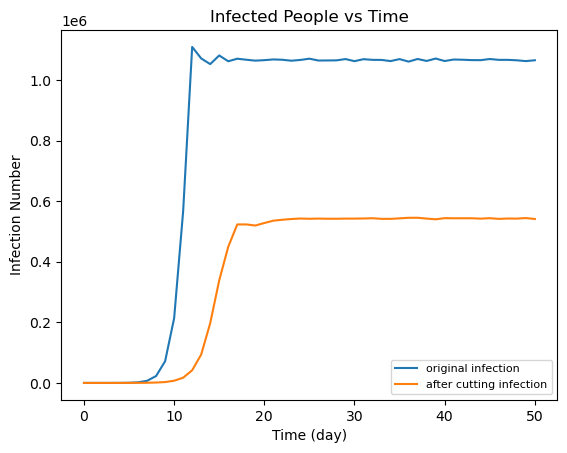

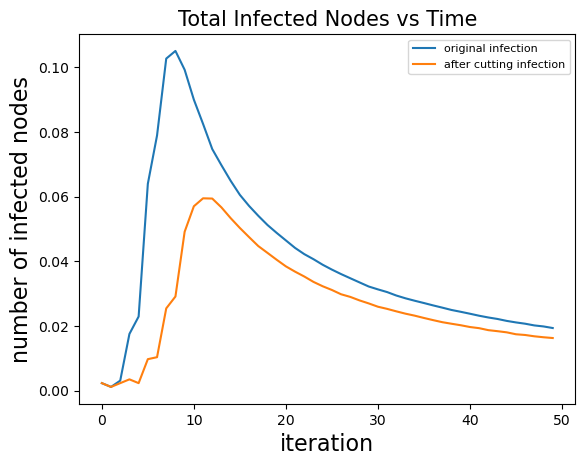

In [344]:
# hits_aut
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'NRT', 'JFK', 'LAX', 'MEL', 'TPE', 'PVG', 'ORD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


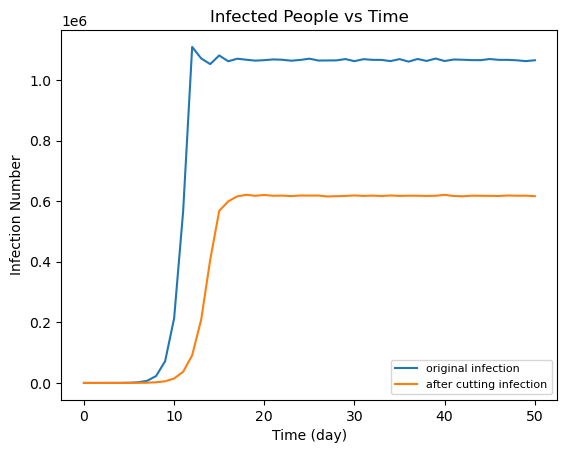

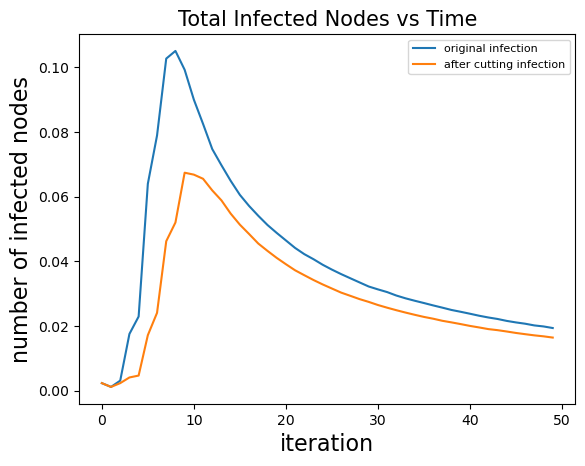

In [345]:
# gls
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MIA', 'CDG', 'HKG', 'YYZ', 'DEL', 'GVA', 'MCO', 'ABV']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## cut top 5 nodes

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


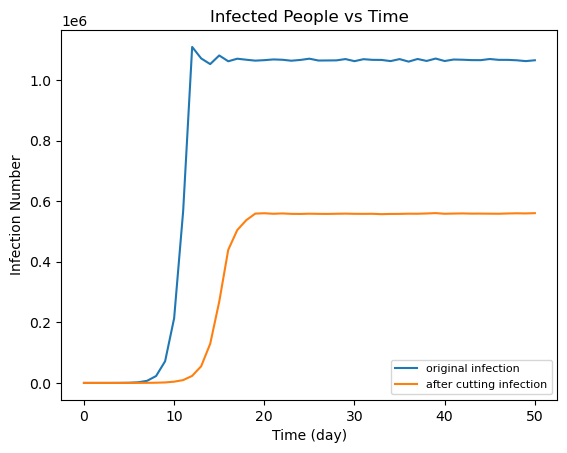

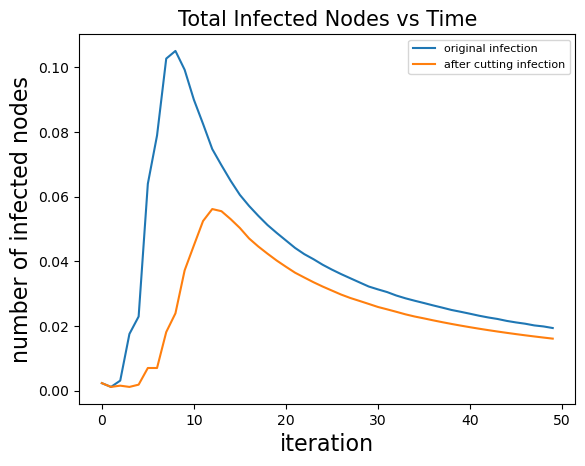

In [346]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MAD', 'MIA', 'HKG']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


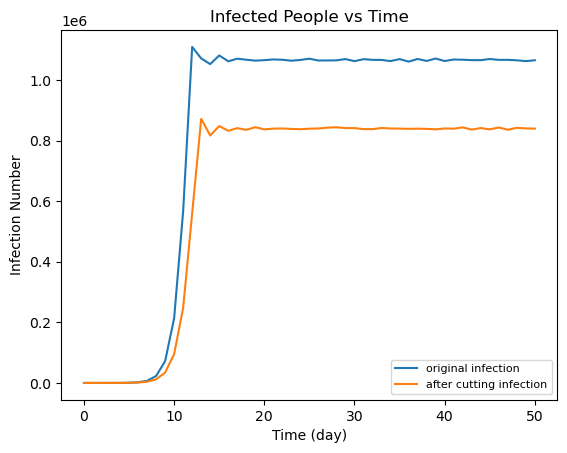

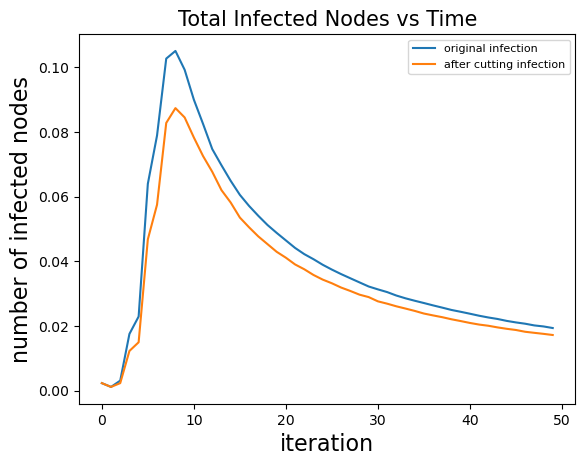

In [347]:
# betweenness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['AMM', 'BCN', 'HKG', 'MAD', 'SCL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


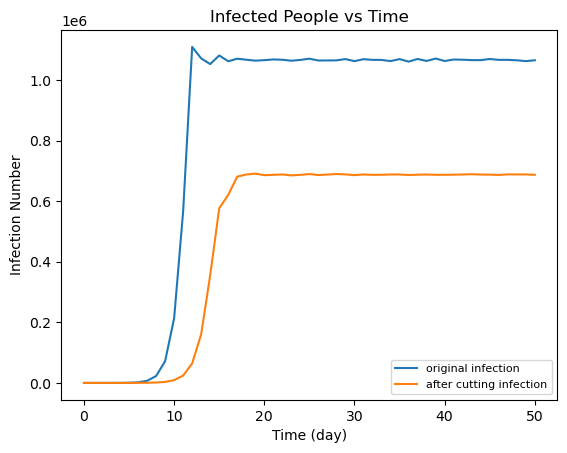

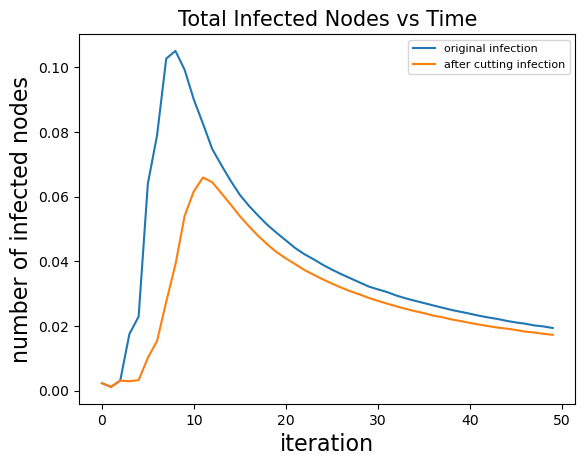

In [348]:
# closeness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'JFK', 'ORD', 'MAD', 'LAX']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


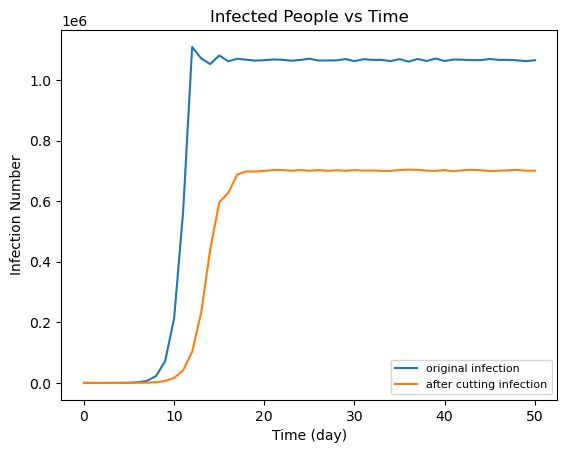

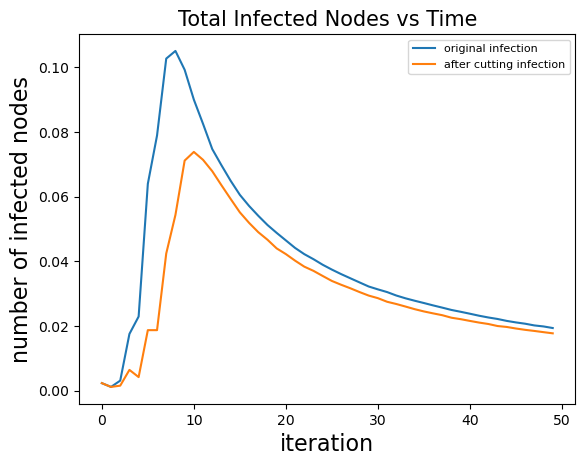

In [349]:
# eigenvector_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'NRT', 'JFK']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


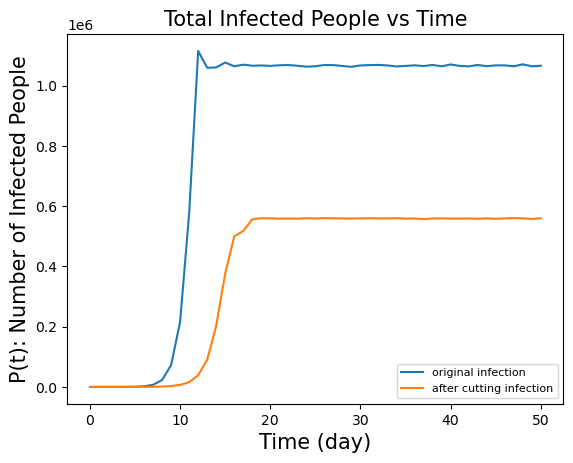

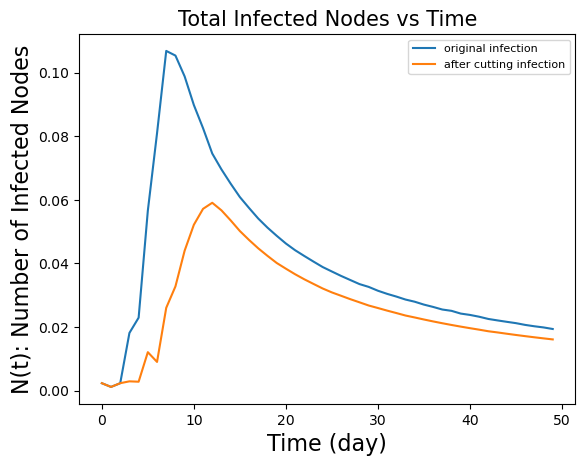

In [393]:
# page_rank
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'ORD', 'MIA', 'HKG', 'MAD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


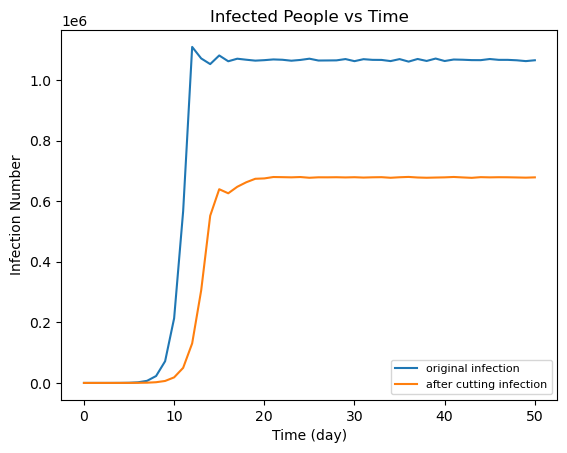

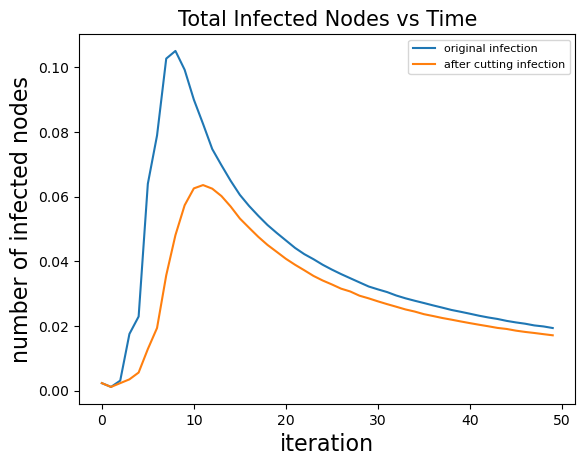

In [351]:
# h_index
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LAX', 'MIA', 'LHR', 'JFK']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


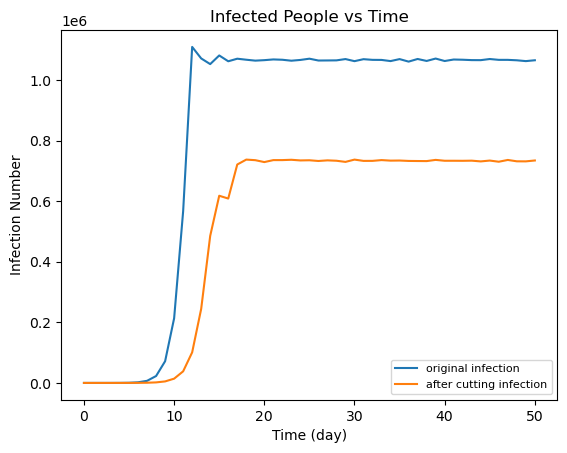

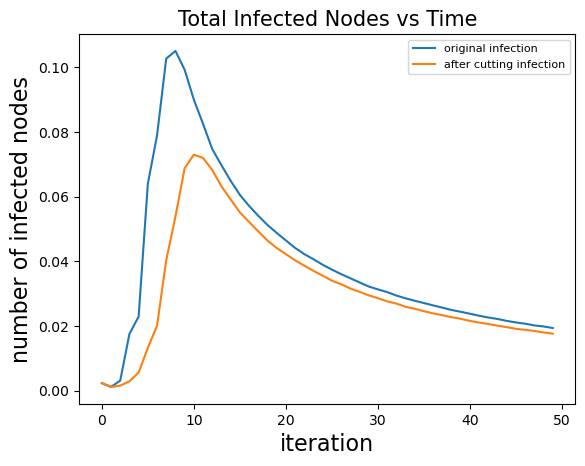

In [352]:
# hits_hub
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'TPE', 'NRT']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


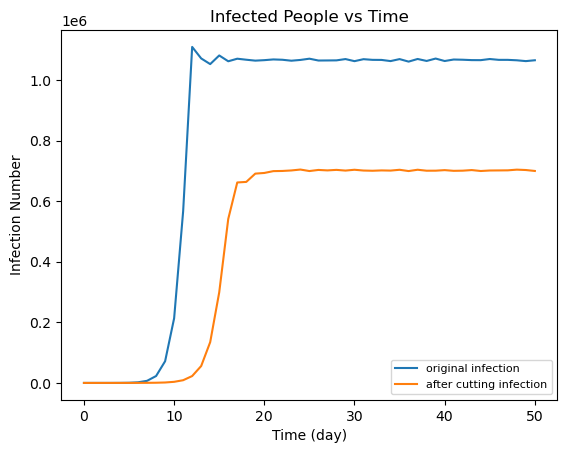

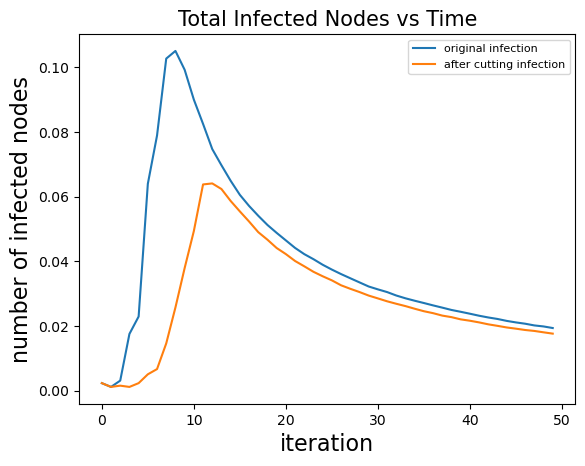

In [353]:
# hits_aut
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD', 'NRT', 'JFK']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


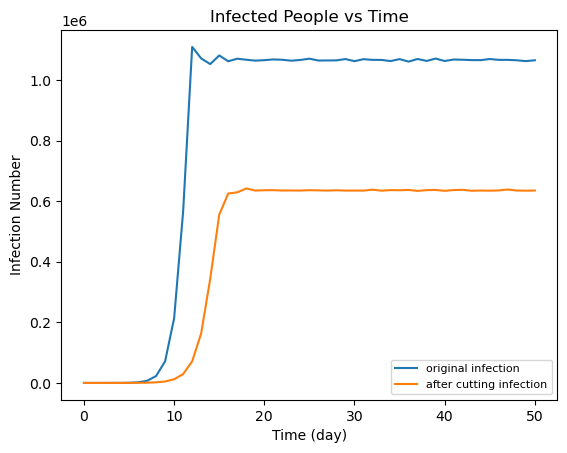

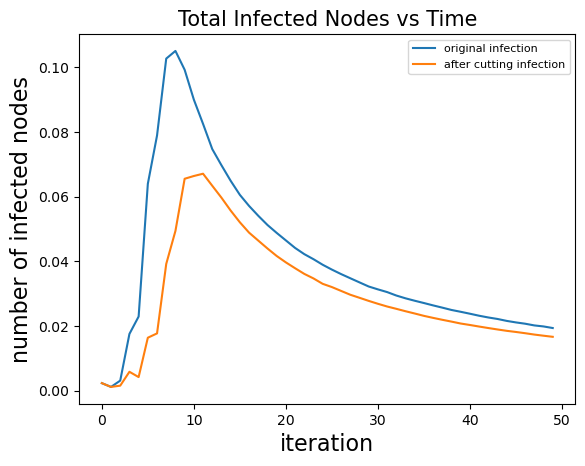

In [354]:
# gls
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MIA', 'CDG', 'HKG']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## cut top 3 nodes

In [355]:
adj = pd.read_csv('./init_flight_capacity.csv')

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


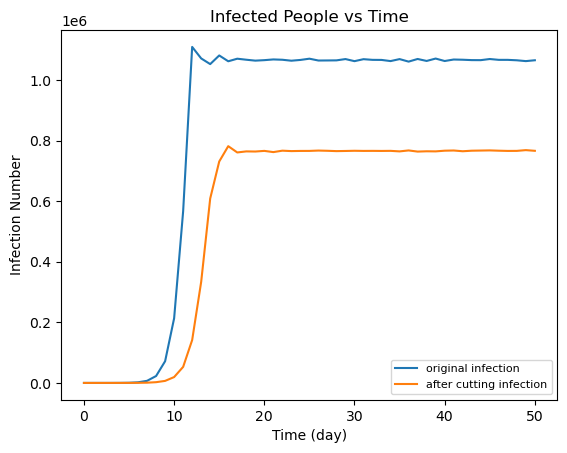

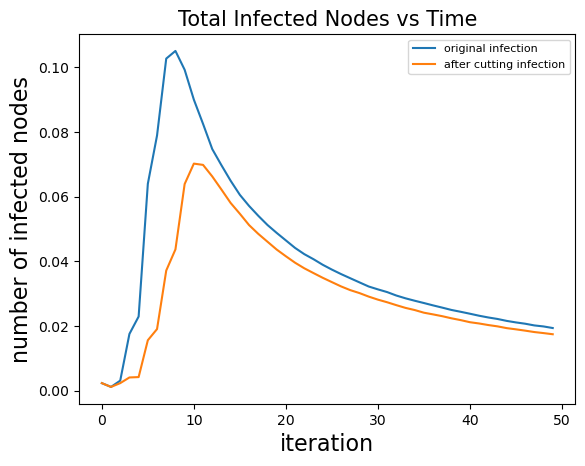

In [356]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MAD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


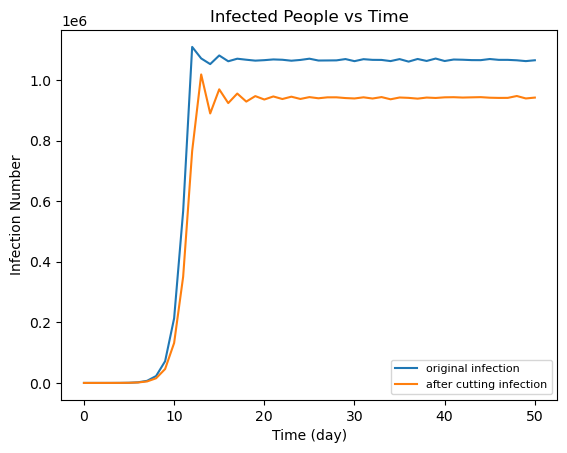

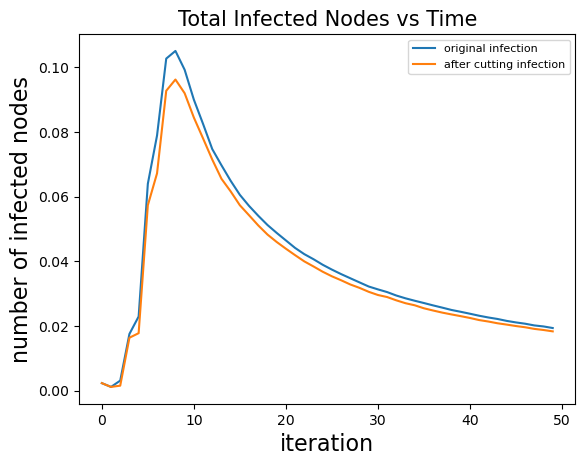

In [357]:
# betweenness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['AMM', 'BCN', 'HKG']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


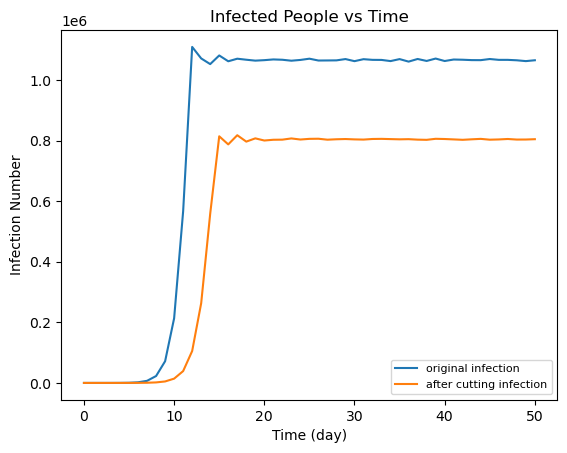

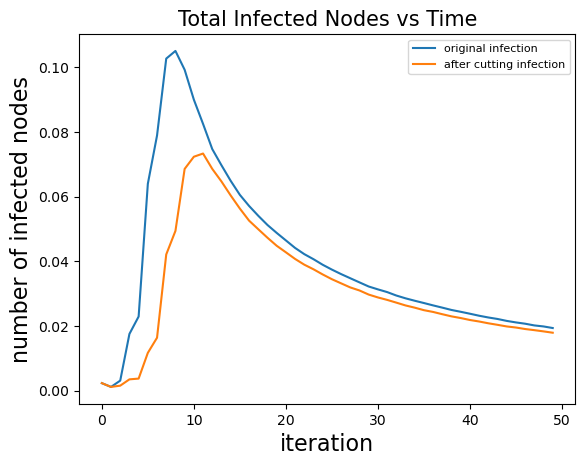

In [358]:
# closeness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'JFK', 'ORD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


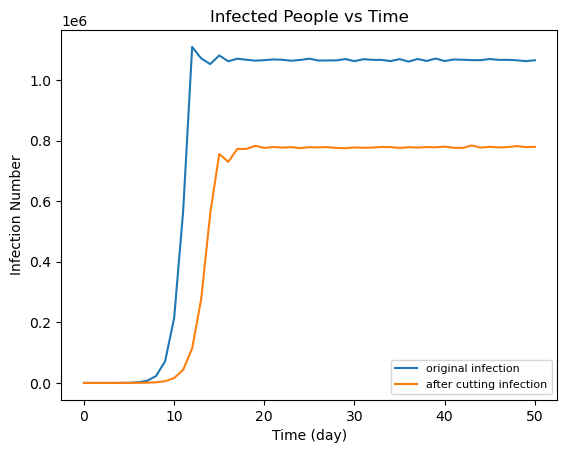

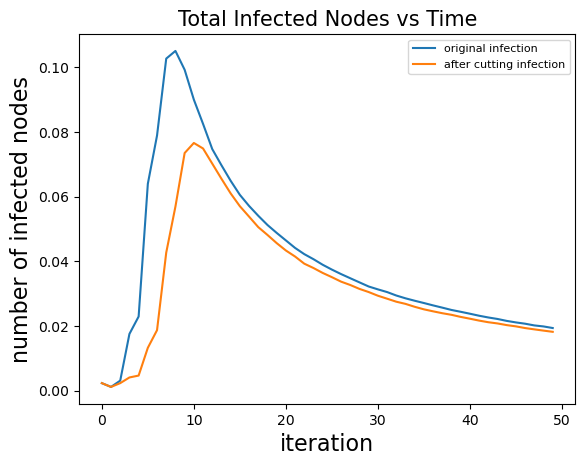

In [359]:
# eigenvector_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


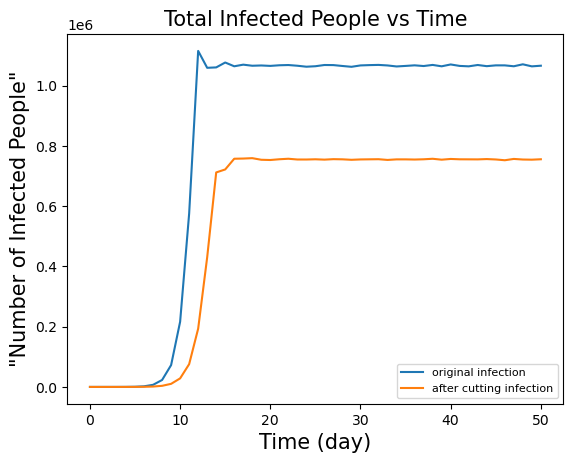

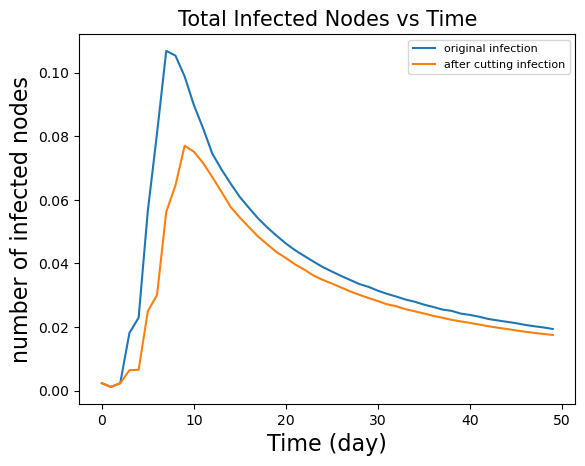

In [382]:
# page_rank
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'ORD', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


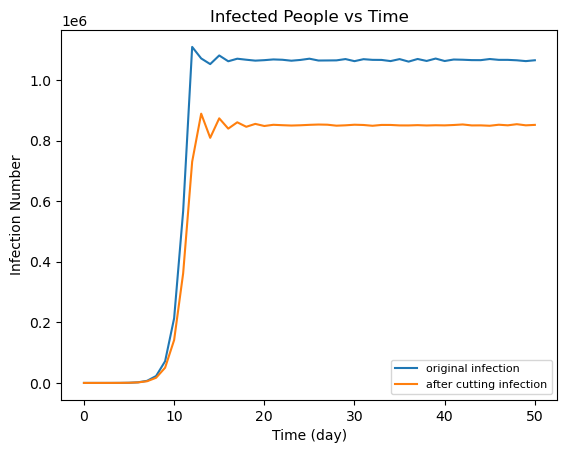

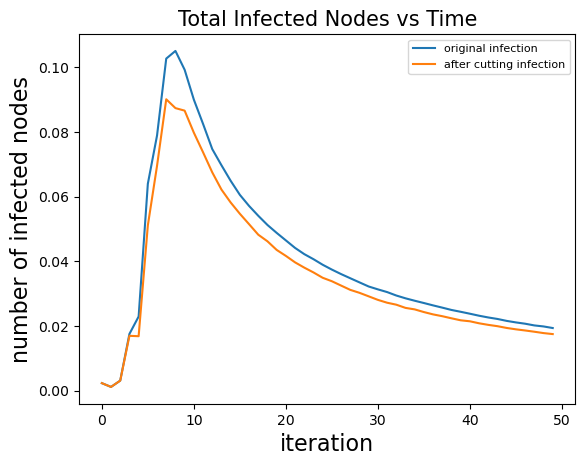

In [361]:
# h_index
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LAX', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


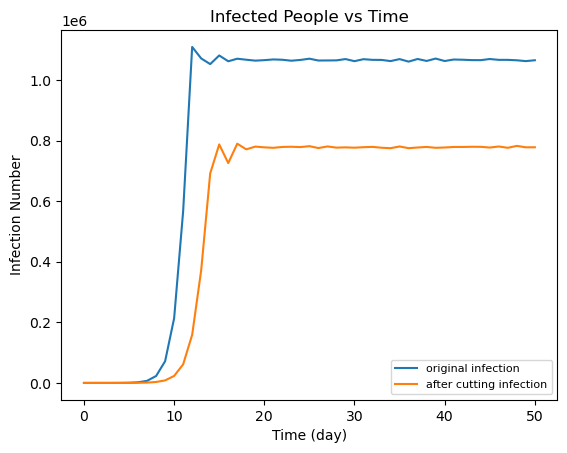

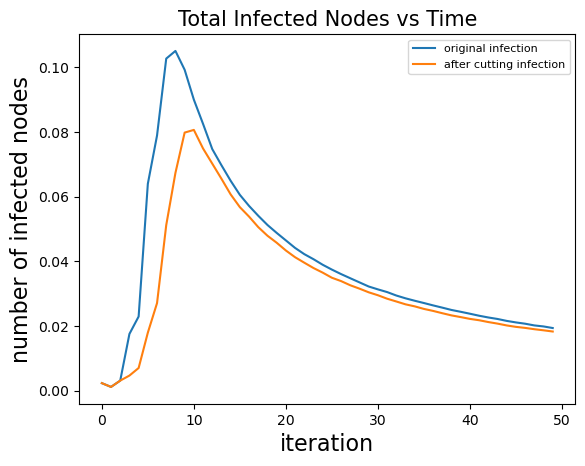

In [362]:
# hits_hub
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


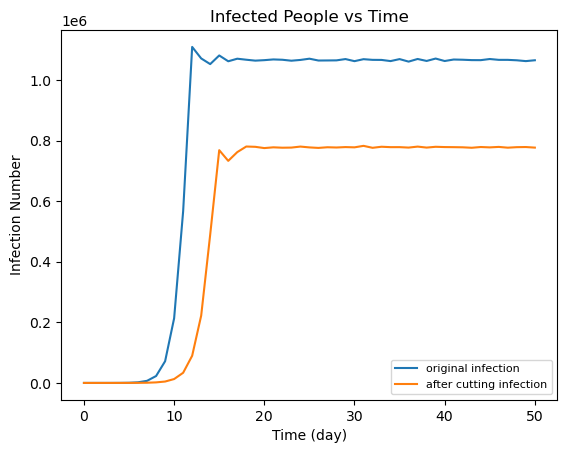

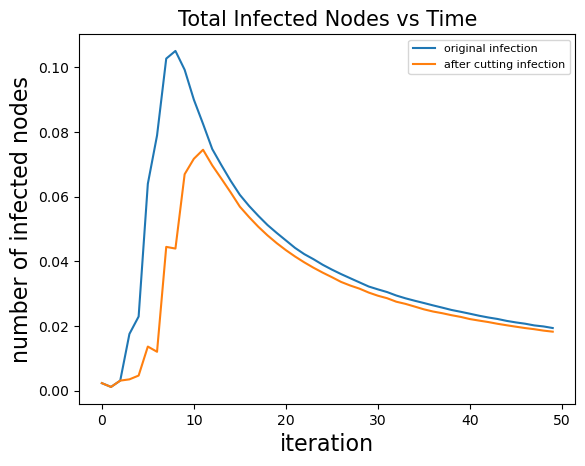

In [363]:
# hits_aut
adj = pd.read_csv('./init_flight_capacity.csv')
l=['HKG', 'LHR', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


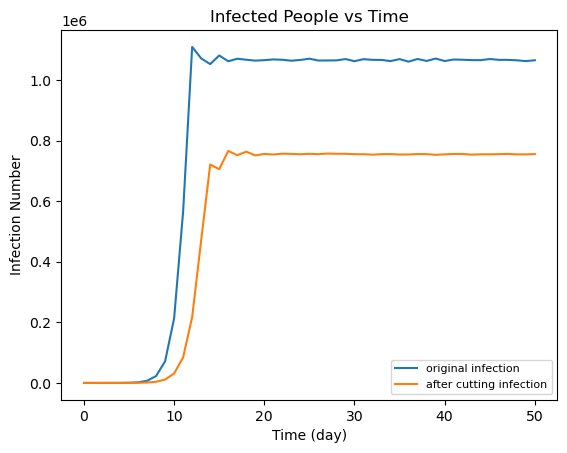

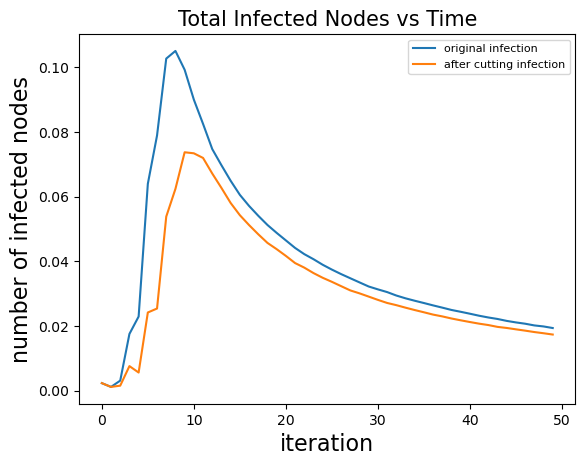

In [364]:
# gls
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MIA']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

## Find node list

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


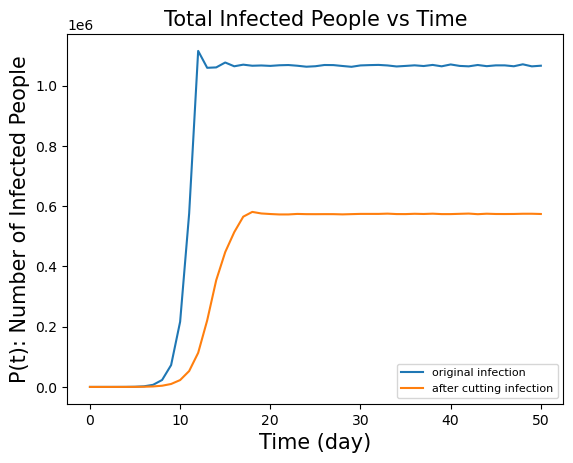

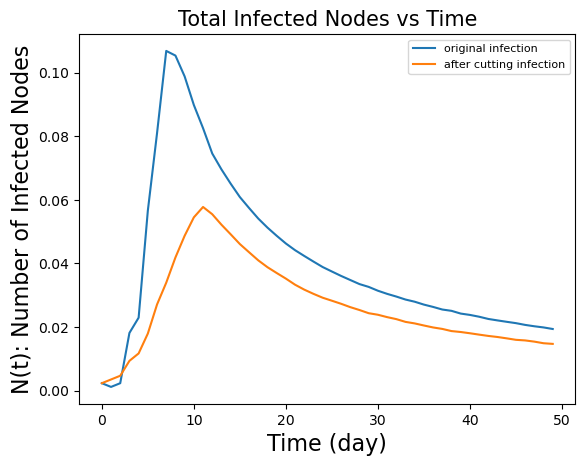

In [477]:
# degree_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['ORD', 'LHR', 'MAD', 'MIA', 'HKG', 'STL', 'HEL', 'LAX', 'BCN', 'NRT', 'JFK', 'AMM', 'LGW','SCL', 'BUD', 'SYD']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


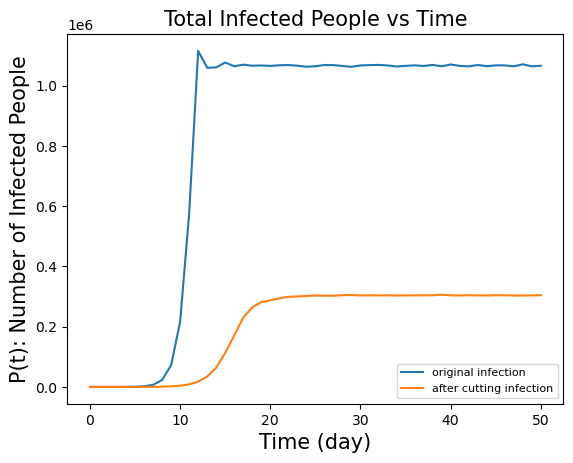

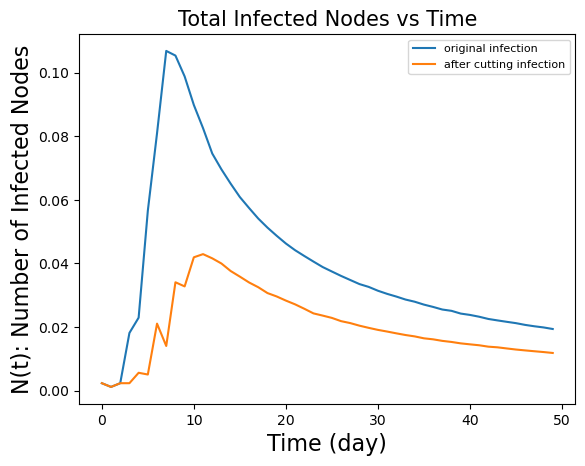

In [470]:
# betweenness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['AMM', 'BCN', 'HKG', 'MAD', 'SCL', 'ORD', 'HEL', 'MIA', 'BOS', 'STL', 'RGS', 'ZAZ', 'HND', 'BUD', 'ORY', 'LIS', 'NRT', 'SYD', 'LIM', 'JFK']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/682146930.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


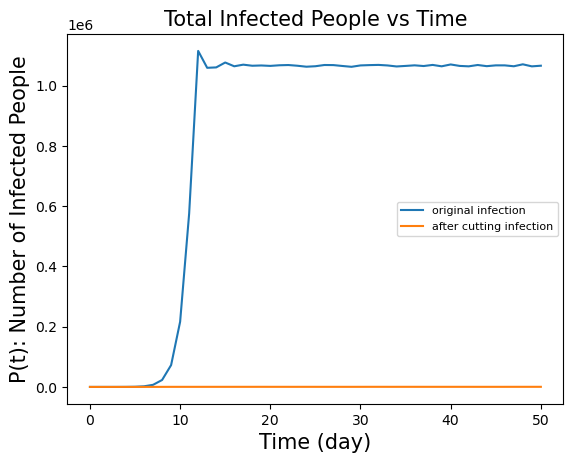

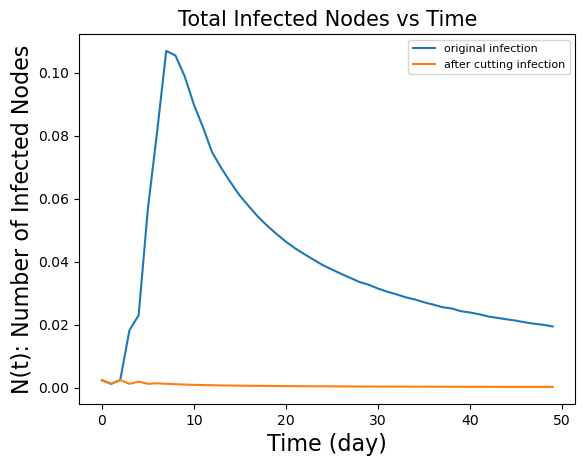

In [401]:
# closeness_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'JFK', 'ORD', 'MAD', 'LAX', 'MIA', 'FRA', 'BCN', 'AMM', 'HKG', 'NRT', 'CDG', 'BOS', 'YYZ', 'SFO', 'HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:61: RuntimeWarning: overflow encountered in multiply
  d0 = S - beta*S*I # derivative of S(t)
/var/folders/zr/6clkkywj73l_1smy895dt5hw0000gn/T/ipykernel_3436/1749187131.py:62: RuntimeWarning: overflow encountered in multiply
  d1 = I + beta*S*I - gamma*I # derivative of I(t)


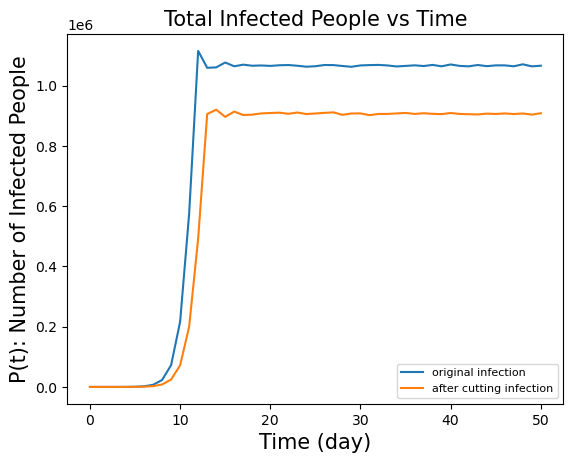

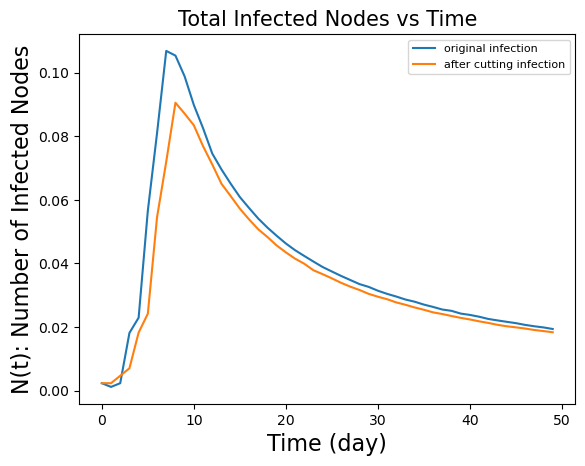

In [437]:
# eigenvector_centrality
adj = pd.read_csv('./init_flight_capacity.csv')
l=['LHR', 'HEL']
adj_matrix=cut_k_nodes(adj, l)
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

  0%|          | 0/50 [00:00<?, ?it/s]

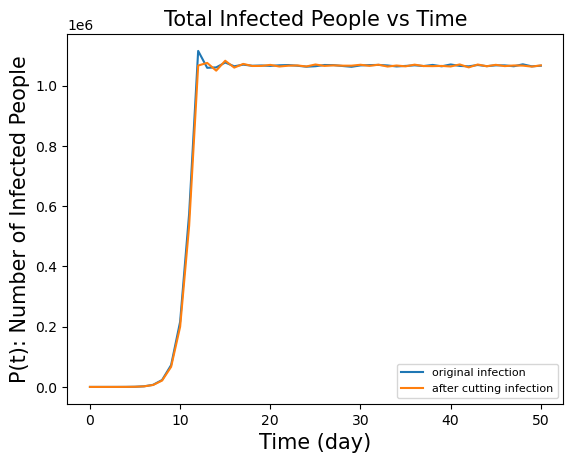

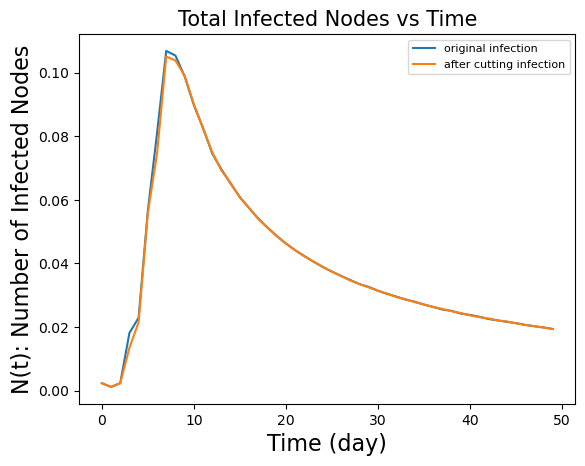

In [433]:
# page_rank
adj = pd.read_csv('./init_flight_capacity.csv')
#l=['LHR', 'ORD', 'MIA']
#adj_matrix=cut_k_nodes(adj, l)
adj_matrix=adj
# iteration
matrix,infection_list,infection_ppl_city_list_,infection_ppl_flight_list_=loop_infection(50, adj_matrix)
# plot
plot_iteration(infection_list)
plt_node_ratio(infection_ppl_flight_list_)

In [ ]:
matrix

In [ ]:
l=[1,2,3]
l[-1]

In [229]:
#print(infection_ppl_city_list_[-1])

In [435]:
#print(infection_ppl_flight_list_[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

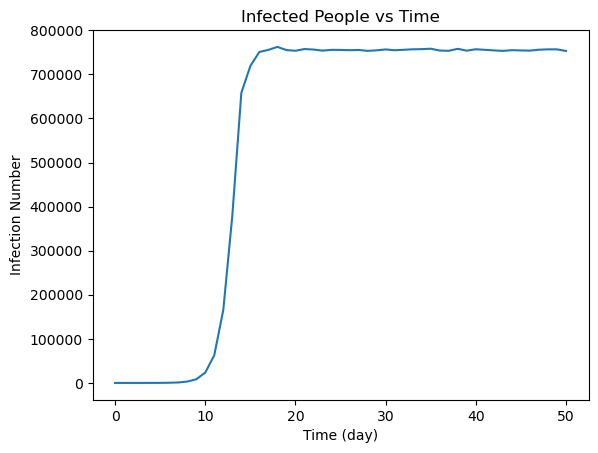

In [232]:
# full
adj = pd.read_csv('./init_flight_capacity.csv')
#l=['ORD', 'LHR', 'MIA']
adj_matrix=adj
# iteration
matrix_b,infection_list_b,infection_ppl_city_list_b,infection_ppl_flight_list_b=loop_infection(50, adj_matrix)


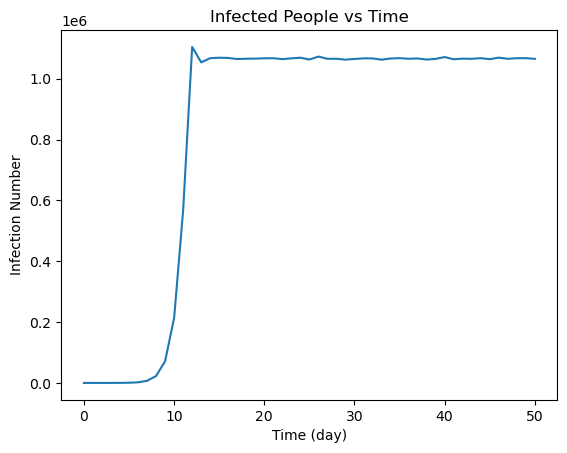

In [233]:
# plot
plot_iteration(infection_list_b)

In [237]:
VVI_REC_FTE=infection_ppl_flight_list_b[-1]

In [239]:
#VVI_REC_FTE

In [395]:
#print(infection_ppl_flight_list_b[-1])